In [ ]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

In [2]:
from dask.distributed import Client

In [3]:
ROMS = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/roms_avg0?_2009.nc')
ROMS_topo = xr.open_dataset('/gxfs_work/geomar/smomw523/master-thesis/data/config/ROMS/topography_parent.nc')

In [4]:
#so viel Minuten um grid box zu durchqueren, mit der Maximalgeschwindigkeit
print(1500/np.sqrt(0.38193586**2+0.4228182**2)/60)

#so viel Minuten um grid box zu durchqueren, mit der Mittelgeschwindigkeit ohne abs eig 0
print(1500/np.sqrt(0.026446715**2+0.02751182**2)/60)

43.87651751789589
655.1040188235088


In [5]:
u = ROMS["u"].isel(s_rho=slice(0,32,31)).mean("time")
v = ROMS["v"].isel(s_rho=slice(0,32,31)).mean("time")

In [6]:
u_interp = u.interp(eta_rho=np.linspace(1.5, 257.5, 257))
v_interp = v.interp(xi_rho=np.linspace(1.5, 237.5, 237))

In [7]:
u_interp = u_interp.rename({'s_rho': 'depth', 'eta_rho': 'eta', 'xi_u': 'xi'})
v_interp = v_interp.rename({'s_rho': 'depth', 'eta_v': 'eta', 'xi_rho': 'xi'})

In [8]:
vel = xr.combine_by_coords([u_interp, v_interp], compat='override', combine_attrs='drop_conflicts')

In [9]:
vel["vel"] = np.sqrt(vel.u**2 + vel.v**2)

In [10]:
vel = vel.assign_coords(xi=vel.isel(eta=0).lon_v, eta = vel.isel(xi=0).lat_u)

In [11]:
vel = vel.compute()

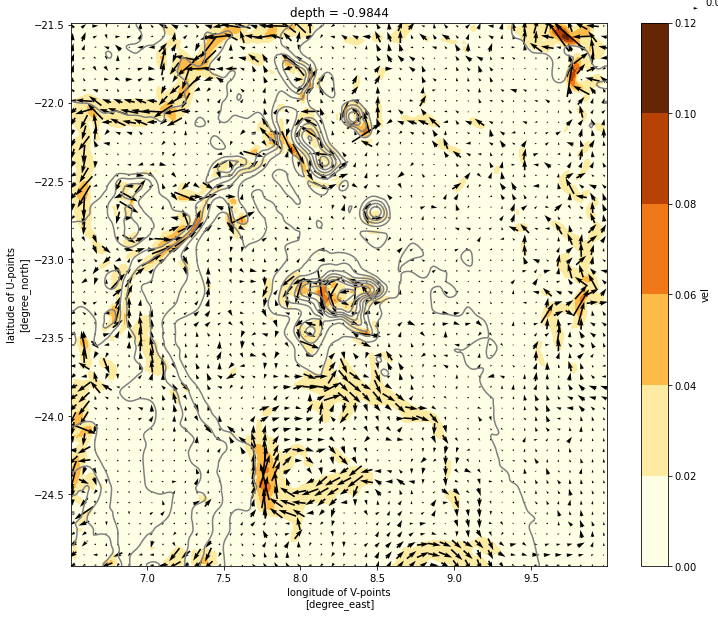

In [12]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

vel.vel.isel(depth=0).plot.contourf(ax=ax, cmap='YlOrBr')
ROMS_topo.topography.plot.contour(ax=ax, colors= 'gray',levels=np.linspace(0,6500,14))

step = 5
vel.isel(depth=0).isel(eta=slice(None, None, step), xi=slice(None, None, step)).plot.quiver(
    x="xi", y="eta", u="u", v="v", ax=ax, scale=1, color='black', width=0.003
)

#plt.xlabel('Längengrad')
#plt.ylabel('Breitengrad')

plt.show()

--------------------------------

### ROMS child

In [13]:
ROMSchild = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/ROMS/roms_avg0?_2009.nc.1')
ROMSchild_topo = xr.open_dataset('/gxfs_work/geomar/smomw523/master-thesis/data/config/ROMS/topography_child.nc')

In [14]:
#so viel Minuten um grid box zu durchqueren, mit der Maximalgeschwindigkeit
print(500/np.sqrt(0.41515973**2+0.44776332**2)/60)

#so viel Minuten um grid box zu durchqueren, mit der Mittelgeschwindigkeit ohne abs eig 0
print(500/np.sqrt(0.034080807**2+0.028038187**2)/60)

13.647462755437536
188.82707348002597


In [15]:
u_RC = ROMSchild["u"].isel(s_rho=slice(0,32,31)).mean("time")
v_RC = ROMSchild["v"].isel(s_rho=slice(0,32,31)).mean("time")

In [16]:
u_RC_interp = u_RC.interp(eta_rho=np.linspace(1.5, 265.5, 265))
v_RC_interp = v_RC.interp(xi_rho=np.linspace(1.5, 265.5, 265))

In [17]:
u_RC_interp = u_RC_interp.rename({'s_rho': 'depth', 'eta_rho': 'eta', 'xi_u': 'xi'})
v_RC_interp = v_RC_interp.rename({'s_rho': 'depth', 'eta_v': 'eta', 'xi_rho': 'xi'})

In [18]:
vel_RC = xr.combine_by_coords([u_RC_interp, v_RC_interp], compat='override', combine_attrs='drop_conflicts')

In [19]:
vel_RC["vel"] = np.sqrt(vel_RC.u**2 + vel_RC.v**2)

In [20]:
vel_RC = vel_RC.assign_coords(xi=vel_RC.isel(eta=0).lon_v, eta = vel_RC.isel(xi=0).lat_u)

In [21]:
vel_RC = vel_RC.compute()

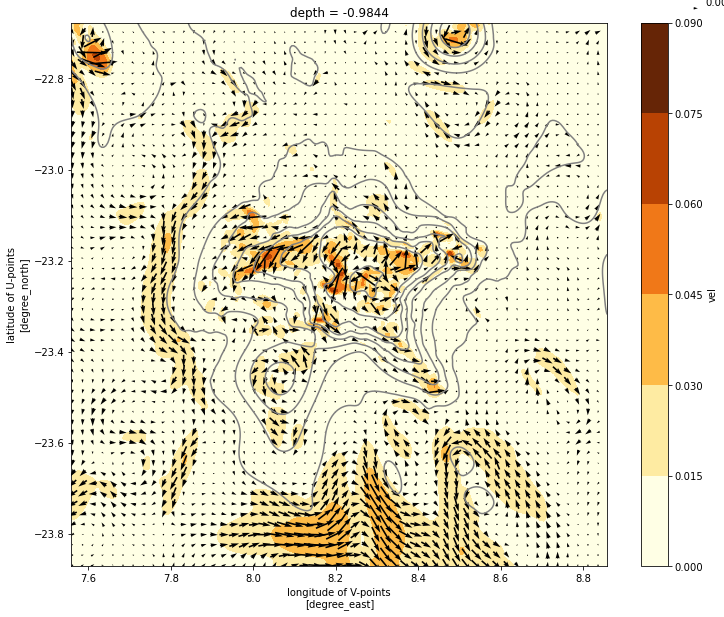

In [22]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

vel_RC.vel.isel(depth=0).plot.contourf(ax=ax, cmap='YlOrBr')
ROMSchild_topo.topography.plot.contour(ax=ax, colors= 'gray',levels=np.linspace(0,6500,14))

step = 5
vel_RC.isel(depth=0).isel(eta=slice(None, None, step), xi=slice(None, None, step)).plot.quiver(
    x="xi", y="eta", u="u", v="v", ax=ax, scale=1, color='black', width=0.003
)

#plt.xlabel('Längengrad')
#plt.ylabel('Breitengrad')

plt.show()

--------------------

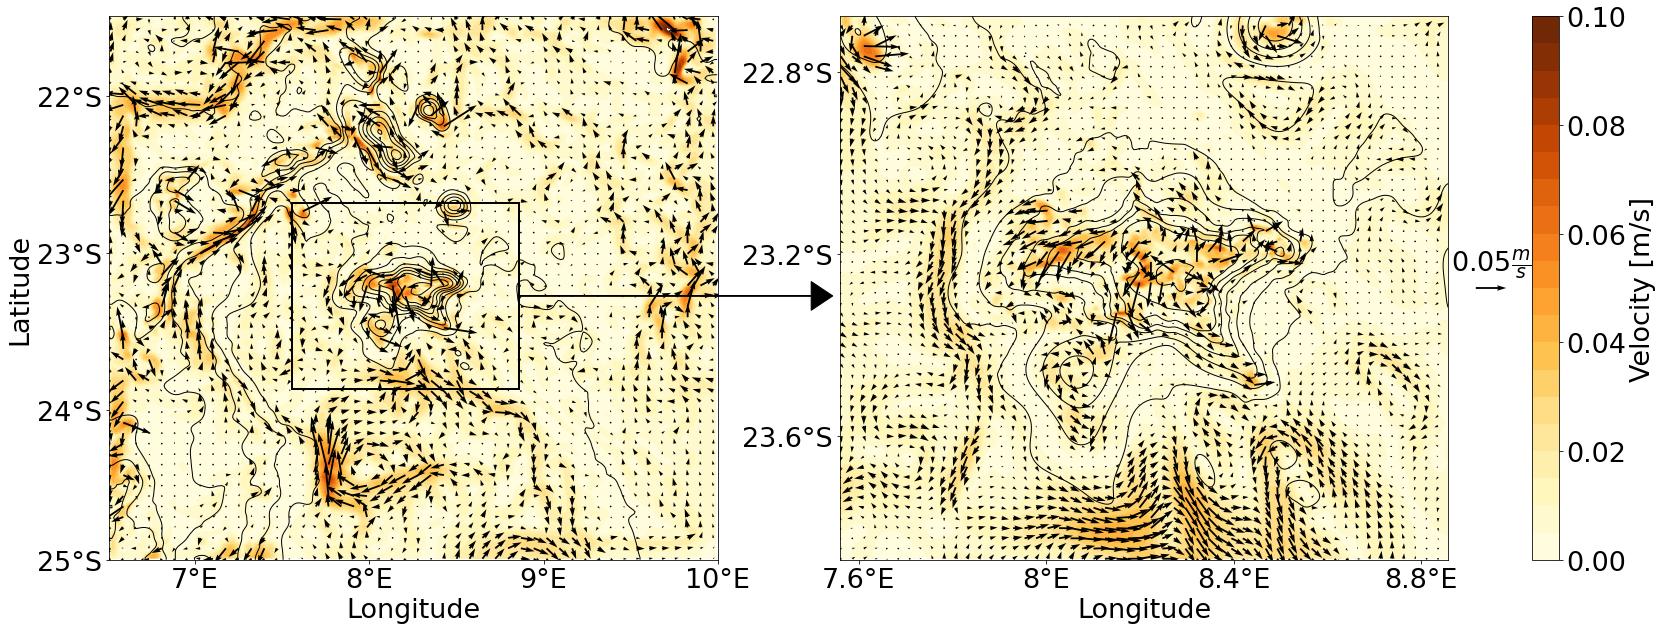

In [23]:
plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

cf = ax1.contourf(vel.xi, vel.eta, vel.vel.isel(depth=0), cmap='YlOrBr', levels=np.linspace(0, 0.1, 21))
ax1.contour(ROMS_topo.lon, ROMS_topo.lat, ROMS_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel = vel.isel(depth=0, eta=slice(None, None, 5), xi=slice(None, None, 5))
ax1.quiver(subset_vel.xi, subset_vel.eta, subset_vel.u, subset_vel.v, scale=1, color='black', width=0.003)

rect = plt.Rectangle((ROMSchild_topo.lon.min(), ROMSchild_topo.lat.min()), ROMSchild_topo.lon.max() - ROMSchild_topo.lon.min(),
                     ROMSchild_topo.lat.max() - ROMSchild_topo.lat.min(), edgecolor='black', facecolor='none', linewidth=2, zorder=3)
ax1.add_patch(rect)
ax1.set_xlabel('Longitude')
ax1.set_xticks([7,8,9,10])
ax1.set_xticklabels(['7°E','8°E','9°E','10°E'])
ax1.set_ylabel('Latitude')
ax1.set_yticks([-24.96,-24,-23,-22])
ax1.set_yticklabels(['25°S','24°S','23°S','22°S'])

cf = ax2.contourf(vel_RC.xi, vel_RC.eta, vel_RC.vel.isel(depth=0), cmap='YlOrBr', levels=np.linspace(0, 0.1, 21))
ax2.contour(ROMSchild_topo.lon, ROMSchild_topo.lat, ROMSchild_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_RC = vel_RC.isel(depth=0, eta=slice(None, None, 5), xi=slice(None, None, 5))
quiver=ax2.quiver(subset_vel_RC.xi, subset_vel_RC.eta, subset_vel_RC.u, subset_vel_RC.v, scale=1, color='black', width=0.003)

ax2.set_xticks([7.6,8,8.4,8.8])
ax2.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax2.set_xlabel('Longitude')
ax2.set_yticks([-23.6,-23.2,-22.8])
ax2.set_yticklabels(['23.6°S','23.2°S','22.8°S'])

ax2.quiverkey(quiver, 1.07, 0.5, 0.05, r'$0.05\frac{m}{s}$', coordinates='axes')

cbar = plt.colorbar(cf, ax=[ax1, ax2], orientation='vertical', ticks=np.linspace(0, 0.1, 6))
cbar.set_label('Velocity [m/s]')

#fig.text(0.146, 0.839, '(a)', ha='center', va='center',color='gray',fontsize=30)
#fig.text(0.145, 0.84, '(a)', ha='center', va='center',color='black',fontsize=30)
#fig.text(0.486, 0.839, '(b)', ha='center', va='center',color='gray',fontsize=30)
#fig.text(0.485, 0.84, '(b)', ha='center', va='center',color='black',fontsize=30)

arrow = patches.FancyArrow(0.315, 0.4915, 0.135, 0, head_width=0.04, head_length=0.01, fc='black', ec='black')
fig.add_artist(arrow)

#plt.savefig('../../output_data/flowfield-ROMS-mean-bottom.png', bbox_inches='tight')


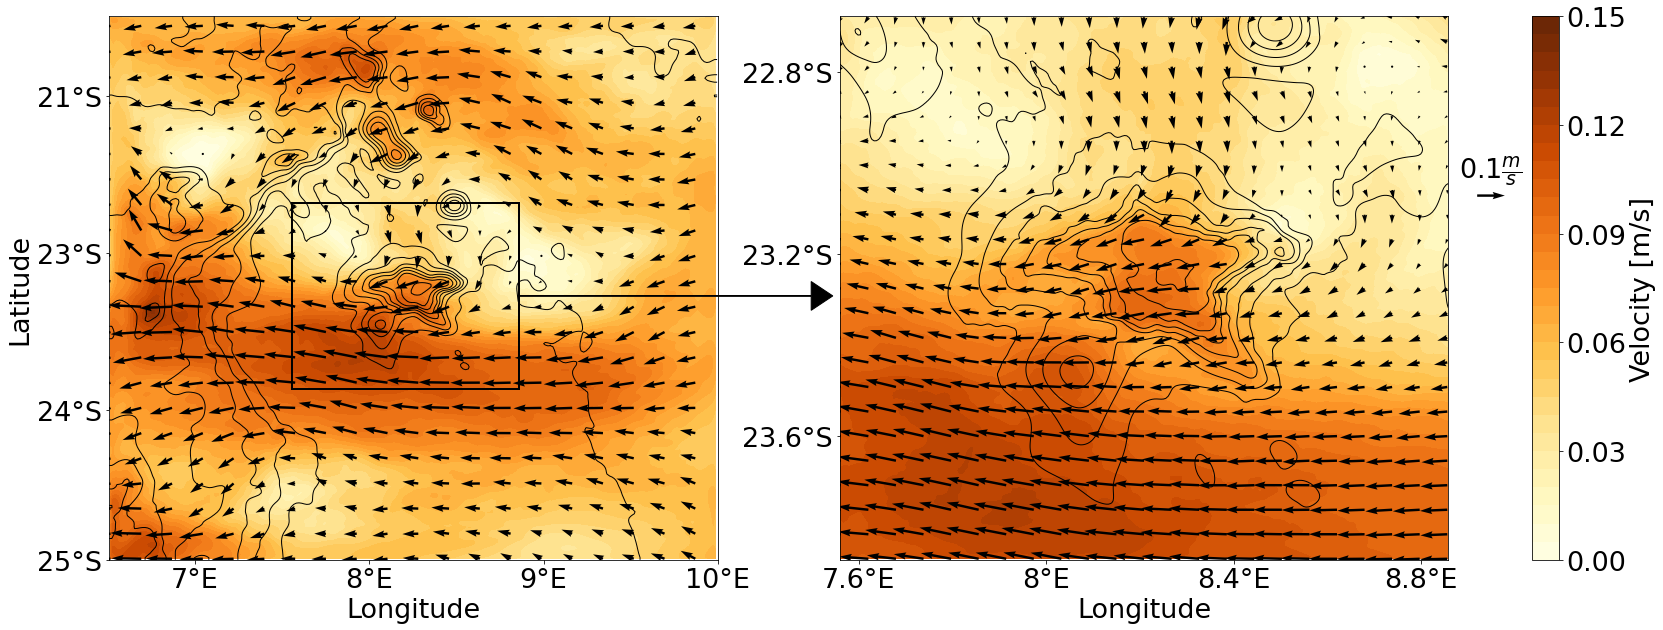

In [24]:
plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

cf = ax1.contourf(vel.xi, vel.eta, vel.vel.isel(depth=1), cmap='YlOrBr', levels=np.linspace(0, 0.15, 31))
ax1.contour(ROMS_topo.lon, ROMS_topo.lat, ROMS_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel = vel.isel(depth=1, eta=slice(None, None, 12), xi=slice(None, None, 12))
ax1.quiver(subset_vel.xi, subset_vel.eta, subset_vel.u, subset_vel.v, scale=2.1, color='black', width=0.004)

rect = plt.Rectangle((ROMSchild_topo.lon.min(), ROMSchild_topo.lat.min()), ROMSchild_topo.lon.max() - ROMSchild_topo.lon.min(),
                     ROMSchild_topo.lat.max() - ROMSchild_topo.lat.min(), edgecolor='black', facecolor='none', linewidth=2, zorder=3)
ax1.add_patch(rect)
ax1.set_xlabel('Longitude')
ax1.set_xticks([7,8,9,10])
ax1.set_xticklabels(['7°E','8°E','9°E','10°E'])
ax1.set_ylabel('Latitude')
ax1.set_yticks([-24.96,-24,-23,-22])
ax1.set_yticklabels(['25°S','24°S','23°S','21°S'])

cf = ax2.contourf(vel_RC.xi, vel_RC.eta, vel_RC.vel.isel(depth=1), cmap='YlOrBr', levels=np.linspace(0, 0.15, 31))
ax2.contour(ROMSchild_topo.lon, ROMSchild_topo.lat, ROMSchild_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_RC = vel_RC.isel(depth=1, eta=slice(None, None, 12), xi=slice(None, None, 12))
quiver= ax2.quiver(subset_vel_RC.xi, subset_vel_RC.eta, subset_vel_RC.u, subset_vel_RC.v, scale=2.2, color='black', width=0.004)

ax2.set_xticks([7.6,8,8.4,8.8])
ax2.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax2.set_xlabel('Longitude')
ax2.set_yticks([-23.6,-23.2,-22.8])
ax2.set_yticklabels(['23.6°S','23.2°S','22.8°S'])

ax2.quiverkey(quiver, 1.07, 0.67, 0.1, r'$0.1 \frac{m}{s}$', coordinates='axes')

cbar = plt.colorbar(cf, ax=[ax1, ax2], orientation='vertical', ticks=np.linspace(0, 0.15, 6))
cbar.set_label('Velocity [m/s]')

#fig.text(0.146, 0.839, '(a)', ha='center', va='center',color='gray',fontsize=40)
#fig.text(0.145, 0.84, '(a)', ha='center', va='center',color='black',fontsize=40)
#fig.text(0.486, 0.839, '(b)', ha='center', va='center',color='gray',fontsize=40)
#fig.text(0.485, 0.84, '(b)', ha='center', va='center',color='black',fontsize=40)

arrow = patches.FancyArrow(0.315, 0.4915, 0.135, 0, head_width=0.04, head_length=0.01, fc='black', ec='black')
fig.add_artist(arrow)

#plt.savefig('../../output_data/flowfield-ROMS-mean-surface.png', bbox_inches='tight')


-------------

In [25]:
%%time

INALT_mask = xr.open_dataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
Ewing_topo = topo_INALT.isel(x=slice(110,220),y=slice(236,359))
U_INALT = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_1d_2009*_grid_U_iMirabilis.nc')
V_INALT = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_1d_2009*_grid_V_iMirabilis.nc')
Ewing_U_INALT = U_INALT.isel(x=slice(110,220),y=slice(236,359)).vozocrtx.compute()
Ewing_V_INALT = V_INALT.isel(x=slice(110,220),y=slice(236,359)).vomecrty.compute()

data_U_filled_INALT = Ewing_U_INALT.where(Ewing_U_INALT != 0, np.nan).ffill(dim='depthu')
data_V_filled_INALT = Ewing_V_INALT.where(Ewing_V_INALT != 0, np.nan).ffill(dim='depthv')
u_INALT = data_U_filled_INALT.isel(depthu=slice(0,46,45)).mean("time_counter")
v_INALT = data_V_filled_INALT.isel(depthv=slice(0,46,45)).mean("time_counter")
u_interp_INALT = u_INALT.rename({'depthu': 'depth'})#, 'eta_rho': 'eta', 'xi_u': 'xi'})
v_interp_INALT = v_INALT.rename({'depthv': 'depth'})#, 'eta_v': 'eta', 'xi_rho': 'xi'})
vel_INALT = xr.combine_by_coords([u_interp_INALT, v_interp_INALT], compat='override', combine_attrs='drop_conflicts')
vel_INALT["vel"] = np.sqrt(vel_INALT.vomecrty**2 + vel_INALT.vozocrtx**2)
vel_INALT = vel_INALT.compute()

CPU times: user 1min 5s, sys: 6.61 s, total: 1min 12s
Wall time: 1min 13s


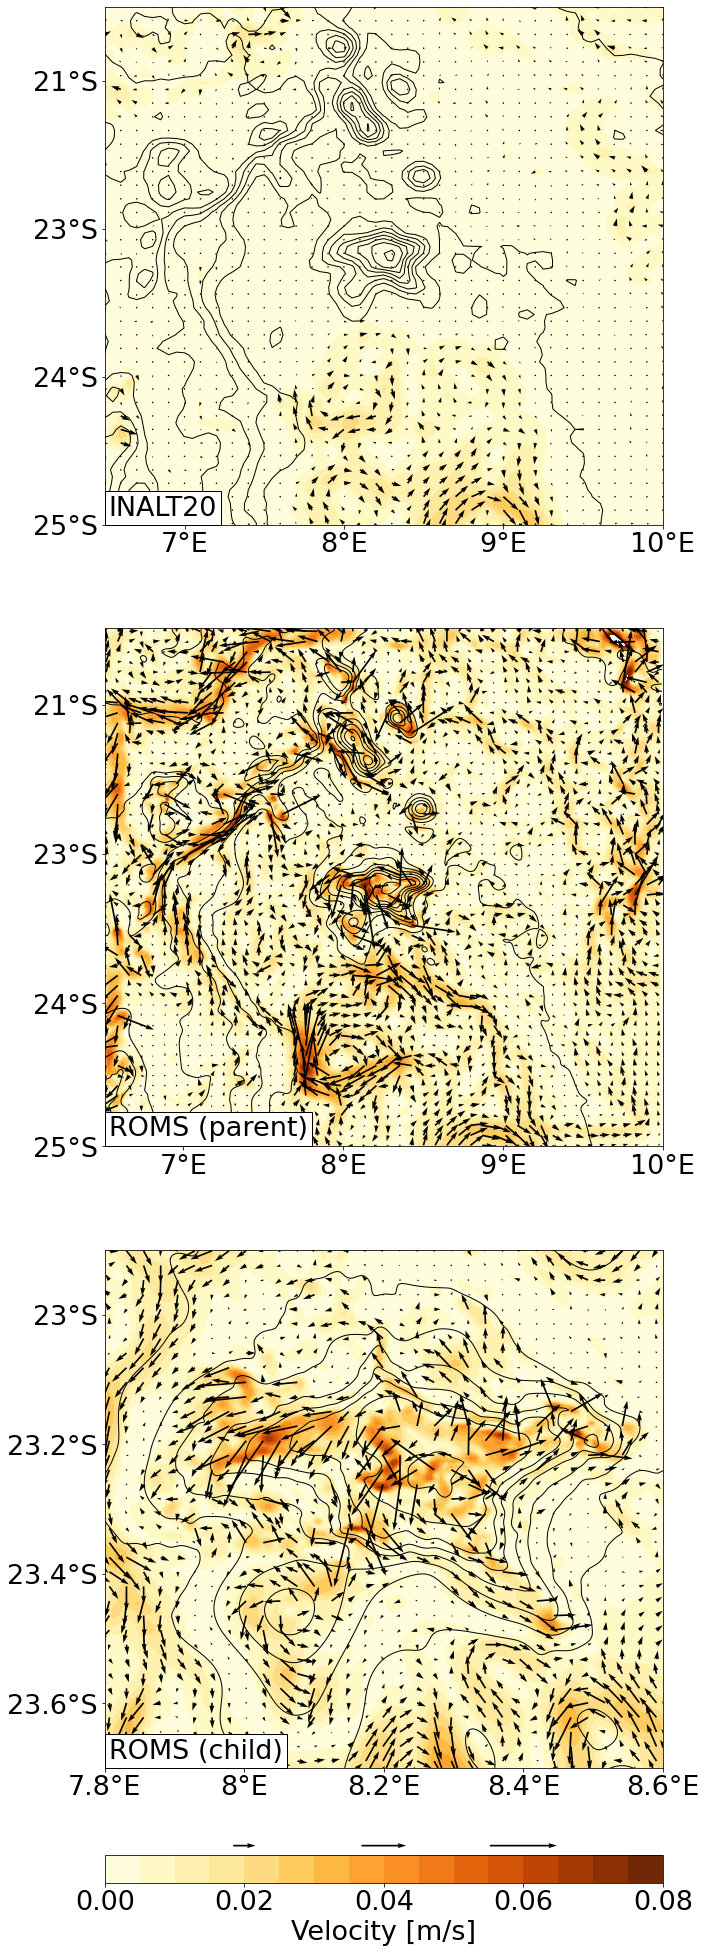

In [26]:
plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 40))

cf = ax1.contourf(vel_INALT.nav_lon, vel_INALT.nav_lat, vel_INALT.vel.isel(depth=1), cmap='YlOrBr', levels=np.linspace(0, 0.08, 17))
ax1.contour(vel_INALT.nav_lon, vel_INALT.nav_lat, Ewing_topo, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_INALT = vel_INALT.isel(depth=1, y=slice(None, None, 2), x=slice(None, None, 2))
ax1.quiver(subset_vel_INALT.nav_lon, subset_vel_INALT.nav_lat, subset_vel_INALT.vozocrtx, subset_vel_INALT.vomecrty, scale=.7, color='black', width=0.003)

ax1.set_xlim([6.5,10])
ax1.set_xticks([7,8,9,10])
ax1.set_xticklabels(['7°E','8°E','9°E','10°E'])
ax1.set_ylim([-25,-21.5])
ax1.set_yticks([-25,-24,-23,-22])
ax1.set_yticklabels(['25°S','24°S','23°S','21°S'])
ax1.text(*(6.525, -24.975),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

cf = ax2.contourf(vel.xi, vel.eta, vel.vel.isel(depth=0), cmap='YlOrBr',levels=np.linspace(0, 0.08, 17))
ax2.contour(ROMS_topo.lon, ROMS_topo.lat, ROMS_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel = vel.isel(depth=0, eta=slice(None, None, 5), xi=slice(None, None, 5))
ax2.quiver(subset_vel.xi, subset_vel.eta, subset_vel.u, subset_vel.v, scale=.7, color='black', width=0.003)

ax2.set_xticks([7,8,9,10])
ax2.set_xticklabels(['7°E','8°E','9°E','10°E'])
#ax2.set_ylabel('Latitude')
ax2.set_yticks([-24.96,-24,-23,-22])
ax2.set_yticklabels(['25°S','24°S','23°S','21°S'])
ax2.text(*(6.535, -24.93),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

cf = ax3.contourf(vel_RC.xi, vel_RC.eta, vel_RC.vel.isel(depth=0), cmap='YlOrBr', levels=np.linspace(0, 0.08, 17))
ax3.contour(ROMSchild_topo.lon, ROMSchild_topo.lat, ROMSchild_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_RC = vel_RC.isel(depth=0, eta=slice(None, None, 5), xi=slice(None, None, 5))
quiver=ax3.quiver(subset_vel_RC.xi, subset_vel_RC.eta, subset_vel_RC.u, subset_vel_RC.v, scale=.5, color='black', width=0.003)

ax3.set_xlim([7.8,8.6])
#ax3.set_xlabel('Longitude')
ax3.set_xticks([7.8,8,8.2,8.4,8.6])
ax3.set_xticklabels(['7.8°E','8°E','8.2°E','8.4°E','8.6°E'])
ax3.set_ylim([-23.7,-22.9])
#ax3.set_ylabel('Latitude')
ax3.set_yticks([-23.6,-23.4,-23.2,-23])
ax3.set_yticklabels(['23.6°S','23.4°S','23.2°S','23°S'])
ax3.text(*(7.806, -23.694),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

ax3.quiverkey(quiver, 0.25, -0.15, 0.02,'', coordinates='axes', linewidth=4)
ax3.quiverkey(quiver, 0.5, -0.15, 0.04,'', coordinates='axes', linewidth=4)
ax3.quiverkey(quiver, 0.75, -0.15, 0.06,'', coordinates='axes', linewidth=4)

cbar = plt.colorbar(cf, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.08, 5))
cbar.set_label('Velocity [m/s]')

#plt.savefig('../../output_data/flowfield-mean-bottom.png', bbox_inches='tight')


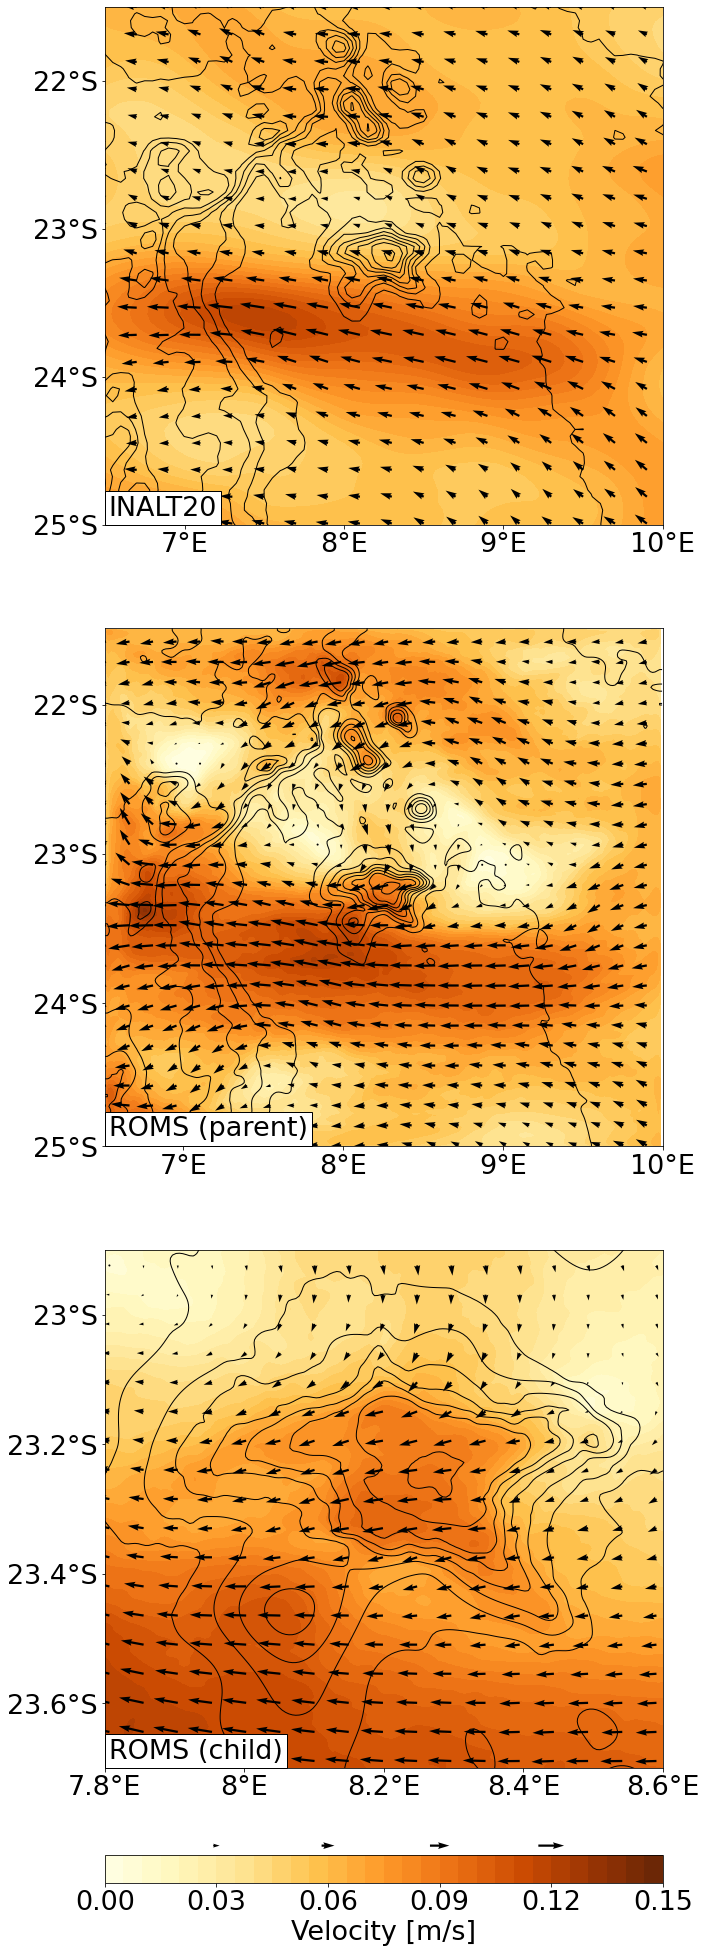

In [27]:
plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 40))

cf = ax1.contourf(vel_INALT.nav_lon, vel_INALT.nav_lat, vel_INALT.vel.isel(depth=0), cmap='YlOrBr', levels=np.linspace(0, 0.15, 31))
ax1.contour(vel_INALT.nav_lon, vel_INALT.nav_lat, Ewing_topo, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_INALT = vel_INALT.isel(depth=0, y=slice(None, None, 4), x=slice(None, None, 4))
ax1.quiver(subset_vel_INALT.nav_lon, subset_vel_INALT.nav_lat, subset_vel_INALT.vozocrtx, subset_vel_INALT.vomecrty, scale=2.6, color='black', width=0.004)

ax1.set_xlim([6.5,10])
ax1.set_xticks([7,8,9,10])
ax1.set_xticklabels(['7°E','8°E','9°E','10°E'])
ax1.set_ylim([-25,-21.5])
ax1.set_yticks([-25,-24,-23,-22])
ax1.set_yticklabels(['25°S','24°S','23°S','22°S'])
ax1.text(*(6.525, -24.975),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

cf = ax2.contourf(vel.xi, vel.eta, vel.vel.isel(depth=1), cmap='YlOrBr',levels=np.linspace(0, 0.15, 31))
ax2.contour(ROMS_topo.lon, ROMS_topo.lat, ROMS_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel = vel.isel(depth=1, eta=slice(None, None, 10), xi=slice(None, None, 10))
ax2.quiver(subset_vel.xi, subset_vel.eta, subset_vel.u, subset_vel.v, scale=2.6, color='black', width=0.004)

ax2.set_xticks([7,8,9,10])
ax2.set_xticklabels(['7°E','8°E','9°E','10°E'])
#ax2.set_ylabel('Latitude')
ax2.set_yticks([-24.96,-24,-23,-22])
ax2.set_yticklabels(['25°S','24°S','23°S','22°S'])
ax2.text(*(6.535, -24.93),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

cf = ax3.contourf(vel_RC.xi, vel_RC.eta, vel_RC.vel.isel(depth=1), cmap='YlOrBr', levels=np.linspace(0, 0.15, 31))
ax3.contour(ROMSchild_topo.lon, ROMSchild_topo.lat, ROMSchild_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_RC = vel_RC.isel(depth=1, eta=slice(None, None, 10), xi=slice(None, None, 10))
quiver=ax3.quiver(subset_vel_RC.xi, subset_vel_RC.eta, subset_vel_RC.u, subset_vel_RC.v, scale=2.6, color='black', width=0.004)

ax3.set_xlim([7.8,8.6])
#ax3.set_xlabel('Longitude')
ax3.set_xticks([7.8,8,8.2,8.4,8.6])
ax3.set_xticklabels(['7.8°E','8°E','8.2°E','8.4°E','8.6°E'])
ax3.set_ylim([-23.7,-22.9])
#ax3.set_ylabel('Latitude')
ax3.set_yticks([-23.6,-23.4,-23.2,-23])
ax3.set_yticklabels(['23.6°S','23.4°S','23.2°S','23°S'])
ax3.text(*(7.806, -23.694),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

ax3.quiverkey(quiver, 0.2, -0.15, 0.03,'', coordinates='axes', linewidth=4)
ax3.quiverkey(quiver, 0.4, -0.15, 0.06,'', coordinates='axes', linewidth=4)
ax3.quiverkey(quiver, 0.6, -0.15, 0.09,'', coordinates='axes', linewidth=4)
ax3.quiverkey(quiver, 0.8, -0.15, 0.12,'', coordinates='axes', linewidth=4)

cbar = plt.colorbar(cf, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.15, 6))
cbar.set_label('Velocity [m/s]')

plt.savefig('../../output_data/flowfield-mean-top.png', bbox_inches='tight')


--------------

In [28]:
%%time

u_INALT_frameI = data_U_filled_INALT.isel(depthu=slice(0,46,45))
v_INALT_frameI = data_V_filled_INALT.isel(depthv=slice(0,46,45))
u_interp_INALT_frameI = u_INALT_frameI.rename({'depthu': 'depth'})#, 'eta_rho': 'eta', 'xi_u': 'xi'})
v_interp_INALT_frameI = v_INALT_frameI.rename({'depthv': 'depth'})#, 'eta_v': 'eta', 'xi_rho': 'xi'})
vel_INALT_frameI = xr.combine_by_coords([u_interp_INALT_frameI, v_interp_INALT_frameI], compat='override', combine_attrs='drop_conflicts')
vel_INALT_frameI["vel"] = np.sqrt(vel_INALT_frameI.vomecrty**2 + vel_INALT_frameI.vozocrtx**2)
vel_INALT_frameI = vel_INALT_frameI.compute()

CPU times: user 32.7 ms, sys: 36.1 ms, total: 68.8 ms
Wall time: 43.8 ms


In [29]:
%%time

u_frameR = ROMS["u"].isel(s_rho=slice(0,32,31))
v_frameR = ROMS["v"].isel(s_rho=slice(0,32,31))

u_interp_frameR = u_frameR.interp(eta_rho=np.linspace(1.5, 257.5, 257))
v_interp_frameR = v_frameR.interp(xi_rho=np.linspace(1.5, 237.5, 237))

u_interp_frameR = u_interp_frameR.rename({'s_rho': 'depth', 'eta_rho': 'eta', 'xi_u': 'xi'})
v_interp_frameR = v_interp_frameR.rename({'s_rho': 'depth', 'eta_v': 'eta', 'xi_rho': 'xi'})

vel_frameR = xr.combine_by_coords([u_interp_frameR, v_interp_frameR], compat='override', combine_attrs='drop_conflicts')

vel_frameR["vel"] = np.sqrt(vel_frameR.u**2 + vel_frameR.v**2)

vel_frameR = vel_frameR.assign_coords(xi=vel_frameR.isel(eta=0).lon_v, eta = vel_frameR.isel(xi=0).lat_u)

vel_frameR = vel_frameR.compute()

CPU times: user 5.41 s, sys: 1.14 s, total: 6.56 s
Wall time: 36.4 s


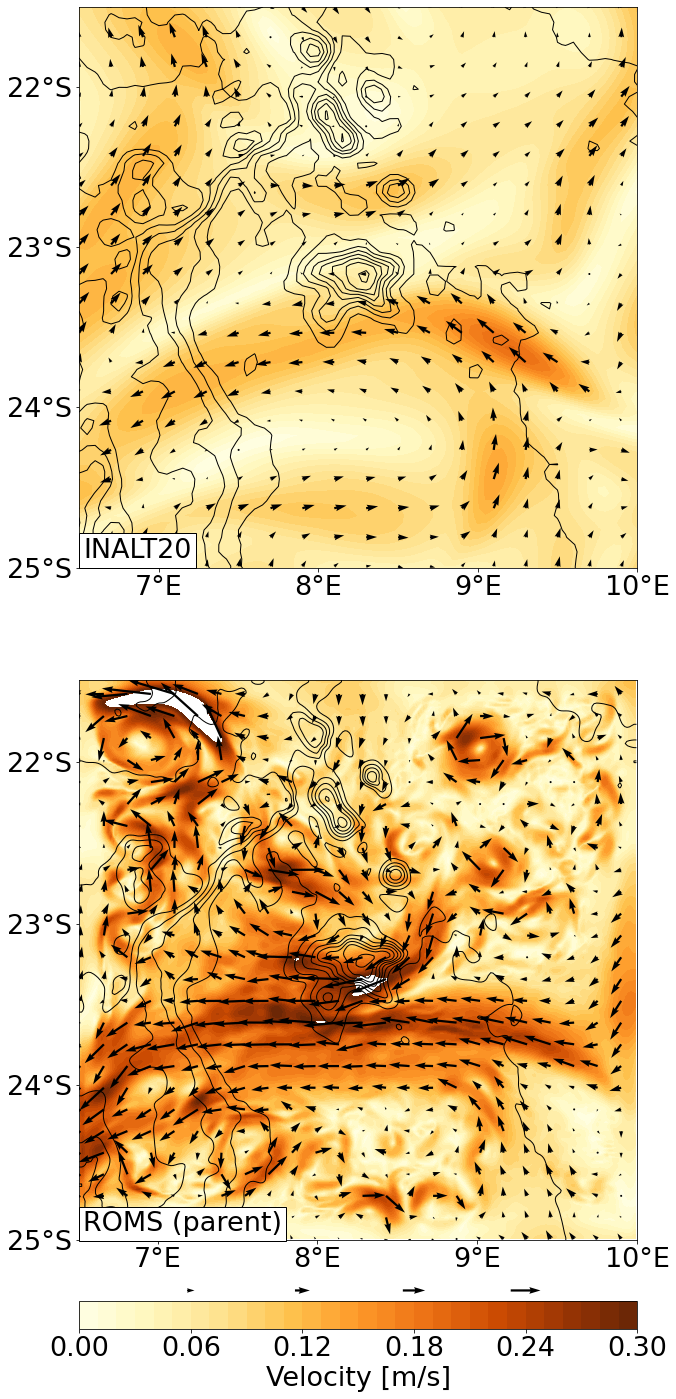

In [53]:
plt.rcParams.update({'font.size': 27})

i = 31 + 150

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 28))

cf = ax1.contourf(vel_INALT_frameI.nav_lon, vel_INALT_frameI.nav_lat, vel_INALT_frameI.vel.isel(depth=0,time_counter=i), cmap='YlOrBr', levels=np.linspace(0, 0.3, 31))
ax1.contour(vel_INALT.nav_lon, vel_INALT.nav_lat, Ewing_topo, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_INALT = vel_INALT_frameI.isel(depth=0,time_counter=i, y=slice(None, None, 4), x=slice(None, None, 4))
ax1.quiver(subset_vel_INALT.nav_lon, subset_vel_INALT.nav_lat, subset_vel_INALT.vozocrtx, subset_vel_INALT.vomecrty, scale=4.5, color='black', width=0.004)

ax1.set_xlim([6.5,10])
ax1.set_xticks([7,8,9,10])
ax1.set_xticklabels(['7°E','8°E','9°E','10°E'])
ax1.set_ylim([-25,-21.5])
ax1.set_yticks([-25,-24,-23,-22])
ax1.set_yticklabels(['25°S','24°S','23°S','22°S'])
ax1.text(*(6.525, -24.975),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

cf = ax2.contourf(vel_frameR.xi, vel_frameR.eta, vel_frameR.vel.isel(depth=1,time=i), cmap='YlOrBr',levels=np.linspace(0, 0.3, 31))
ax2.contour(ROMS_topo.lon, ROMS_topo.lat, ROMS_topo.topography, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel = vel_frameR.isel(depth=1,time=i, eta=slice(None, None, 10), xi=slice(None, None, 10))
quiver = ax2.quiver(subset_vel.xi, subset_vel.eta, subset_vel.u, subset_vel.v, scale=4.5, color='black', width=0.004)

ax2.set_xticks([7,8,9,10])
ax2.set_xticklabels(['7°E','8°E','9°E','10°E'])
#ax2.set_ylabel('Latitude')
ax2.set_yticks([-24.96,-24,-23,-22])
ax2.set_yticklabels(['25°S','24°S','23°S','22°S'])
ax2.text(*(6.535, -24.94),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

ax2.quiverkey(quiver, 0.2, -0.09, 0.06,'', coordinates='axes', linewidth=4)
ax2.quiverkey(quiver, 0.4, -0.09, 0.12,'', coordinates='axes', linewidth=4)
ax2.quiverkey(quiver, 0.6, -0.09, 0.18,'', coordinates='axes', linewidth=4)
ax2.quiverkey(quiver, 0.8, -0.09, 0.24,'', coordinates='axes', linewidth=4)

cbar = plt.colorbar(cf, ax=[ax1, ax2], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.3, 6))
cbar.set_label('Velocity [m/s]')

plt.savefig('../../output_data/flowfield-aug1-top.png', bbox_inches='tight')


-----

In [31]:
%%time

Ewing_topo_zon = topo_INALT.isel(x=slice(110,220),y=295)
Ewing_topo_mer = topo_INALT.isel(x=165,y=slice(236,359))

W_INALT = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_1d_2009*_grid_W_iMirabilis.nc')
Ewing_U_INALT_zon = U_INALT.isel(x=slice(110,220),y=295).vozocrtx.mean("time_counter").compute()
Ewing_V_INALT_zon = V_INALT.isel(x=slice(110,220),y=295).vomecrty.mean("time_counter").compute()
Ewing_W_INALT_zon = W_INALT.isel(x=slice(110,220),y=295).vovecrtz.mean("time_counter").compute()

Ewing_U_INALT_mer = U_INALT.isel(x=165,y=slice(236,359)).vozocrtx.mean("time_counter").compute()
Ewing_V_INALT_mer = V_INALT.isel(x=165,y=slice(236,359)).vomecrty.mean("time_counter").compute()
Ewing_W_INALT_mer = W_INALT.isel(x=165,y=slice(236,359)).vovecrtz.mean("time_counter").compute()

Ewing_U_INALT_zon, Ewing_U_INALT_mer = Ewing_U_INALT_zon.rename({'depthu': 'depth'}), Ewing_U_INALT_mer.rename({'depthu': 'depth'})
Ewing_V_INALT_zon, Ewing_V_INALT_mer = Ewing_V_INALT_zon.rename({'depthv': 'depth'}), Ewing_V_INALT_mer.rename({'depthv': 'depth'})
Ewing_W_INALT_zon, Ewing_W_INALT_mer = Ewing_W_INALT_zon.rename({'depthw': 'depth'}), Ewing_W_INALT_mer.rename({'depthw': 'depth'})

Ewing_U_INALT_zon['depth'] = Ewing_W_INALT_zon.depth
Ewing_V_INALT_zon['depth'] = Ewing_W_INALT_zon.depth
Ewing_U_INALT_mer['depth'] = Ewing_W_INALT_mer.depth
Ewing_V_INALT_mer['depth'] = Ewing_W_INALT_mer.depth


velW_INALT_zon = xr.combine_by_coords([Ewing_U_INALT_zon, Ewing_V_INALT_zon, Ewing_W_INALT_zon], compat='override', combine_attrs='drop_conflicts')
velW_INALT_zon["vel"] = np.sqrt(velW_INALT_zon.vomecrty**2 + velW_INALT_zon.vozocrtx**2 + velW_INALT_zon.vovecrtz**2)
velW_INALT_zon = velW_INALT_zon.compute()

velW_INALT_mer = xr.combine_by_coords([Ewing_U_INALT_mer, Ewing_V_INALT_mer, Ewing_W_INALT_mer], compat='override', combine_attrs='drop_conflicts')
velW_INALT_mer["vel"] = np.sqrt(velW_INALT_mer.vomecrty**2 + velW_INALT_mer.vozocrtx**2 + velW_INALT_mer.vovecrtz**2)
velW_INALT_mer = velW_INALT_mer.compute()

CPU times: user 2min 4s, sys: 8 s, total: 2min 12s
Wall time: 2min 21s


In [32]:
Ewing_U_INALT_mer_1 = U_INALT.isel(x=162,y=slice(236,359)).vozocrtx.mean("time_counter").compute()
Ewing_V_INALT_mer_1 = V_INALT.isel(x=162,y=slice(236,359)).vomecrty.mean("time_counter").compute()
Ewing_W_INALT_mer_1 = W_INALT.isel(x=162,y=slice(236,359)).vovecrtz.mean("time_counter").compute()

Ewing_U_INALT_mer_2 = U_INALT.isel(x=170,y=slice(236,359)).vozocrtx.mean("time_counter").compute()
Ewing_V_INALT_mer_2 = V_INALT.isel(x=170,y=slice(236,359)).vomecrty.mean("time_counter").compute()
Ewing_W_INALT_mer_2 = W_INALT.isel(x=170,y=slice(236,359)).vovecrtz.mean("time_counter").compute()

Ewing_U_INALT_mer_1, Ewing_U_INALT_mer_2 = Ewing_U_INALT_mer_1.rename({'depthu': 'depth'}), Ewing_U_INALT_mer_2.rename({'depthu': 'depth'})
Ewing_V_INALT_mer_1, Ewing_V_INALT_mer_2 = Ewing_V_INALT_mer_1.rename({'depthv': 'depth'}), Ewing_V_INALT_mer_2.rename({'depthv': 'depth'})
Ewing_W_INALT_mer_1, Ewing_W_INALT_mer_2 = Ewing_W_INALT_mer_1.rename({'depthw': 'depth'}), Ewing_W_INALT_mer_2.rename({'depthw': 'depth'})

Ewing_U_INALT_mer_1['depth'] = Ewing_W_INALT_mer_1.depth
Ewing_V_INALT_mer_1['depth'] = Ewing_W_INALT_mer_1.depth
Ewing_U_INALT_mer_2['depth'] = Ewing_W_INALT_mer_2.depth
Ewing_V_INALT_mer_2['depth'] = Ewing_W_INALT_mer_2.depth

velW_INALT_mer_1 = xr.combine_by_coords([Ewing_U_INALT_mer_1, Ewing_V_INALT_mer_1, Ewing_W_INALT_mer_1], compat='override', combine_attrs='drop_conflicts')
velW_INALT_mer_1["vel"] = np.sqrt(velW_INALT_mer_1.vomecrty**2 + velW_INALT_mer_1.vozocrtx**2 + velW_INALT_mer_1.vovecrtz**2)
velW_INALT_mer_1 = velW_INALT_mer_1.compute()

velW_INALT_mer_2 = xr.combine_by_coords([Ewing_U_INALT_mer_2, Ewing_V_INALT_mer_2, Ewing_W_INALT_mer_2], compat='override', combine_attrs='drop_conflicts')
velW_INALT_mer_2["vel"] = np.sqrt(velW_INALT_mer_2.vomecrty**2 + velW_INALT_mer_2.vozocrtx**2 + velW_INALT_mer_2.vovecrtz**2)
velW_INALT_mer_2 = velW_INALT_mer_2.compute()

In [33]:
%%time

u_W_ROMS = ROMS["u"].mean("time")
v_W_ROMS = ROMS["v"].mean("time")
w_W_ROMS = ROMS["w"].mean("time")

u_interp_W_ROMS = u_W_ROMS.interp(eta_rho=np.linspace(1.5, 257.5, 257))
v_interp_W_ROMS = v_W_ROMS.interp(xi_rho=np.linspace(1.5, 237.5, 237))
w_interp_W_ROMS = w_W_ROMS.interp(xi_rho=np.linspace(1.5, 237.5, 237), eta_rho=np.linspace(1.5, 257.5, 257))

u_interp_W_ROMS = u_interp_W_ROMS.rename({'s_rho': 'depth', 'eta_rho': 'eta', 'xi_u': 'xi'})
v_interp_W_ROMS = v_interp_W_ROMS.rename({'s_rho': 'depth', 'eta_v': 'eta', 'xi_rho': 'xi'})
w_interp_W_ROMS = w_interp_W_ROMS.rename({'s_rho': 'depth', 'eta_rho': 'eta', 'xi_rho': 'xi'})

vel_W_ROMS = xr.combine_by_coords([u_interp_W_ROMS, v_interp_W_ROMS, w_interp_W_ROMS],
                                  compat='override', combine_attrs='drop_conflicts')
vel_W_ROMS["vel"] = np.sqrt(vel_W_ROMS.u**2 + vel_W_ROMS.v**2 + vel_W_ROMS.w**2)

vel_W_ROMS = vel_W_ROMS.assign_coords(xi=vel_W_ROMS.isel(eta=0).lon_v, eta = vel_W_ROMS.isel(xi=0).lat_u)

vel_W_ROMS = vel_W_ROMS.compute()

CPU times: user 6.19 s, sys: 5.23 s, total: 11.4 s
Wall time: 49.7 s


In [34]:
%%time

u_W_ROMSchild = ROMSchild["u"].mean("time")
v_W_ROMSchild = ROMSchild["v"].mean("time")
w_W_ROMSchild = ROMSchild["w"].mean("time")

u_interp_W_ROMSchild = u_W_ROMSchild.interp(eta_rho=np.linspace(1.5, 265.5, 265))
v_interp_W_ROMSchild = v_W_ROMSchild.interp(xi_rho=np.linspace(1.5, 265.5, 265))
w_interp_W_ROMSchild = w_W_ROMSchild.interp(xi_rho=np.linspace(1.5, 265.5, 265), eta_rho=np.linspace(1.5, 265.5, 265))

u_interp_W_ROMSchild = u_interp_W_ROMSchild.rename({'s_rho': 'depth', 'eta_rho': 'eta', 'xi_u': 'xi'})
v_interp_W_ROMSchild = v_interp_W_ROMSchild.rename({'s_rho': 'depth', 'eta_v': 'eta', 'xi_rho': 'xi'})
w_interp_W_ROMSchild = w_interp_W_ROMSchild.rename({'s_rho': 'depth', 'eta_rho': 'eta', 'xi_rho': 'xi'})

vel_W_ROMSchild = xr.combine_by_coords([u_interp_W_ROMSchild, v_interp_W_ROMSchild, w_interp_W_ROMSchild],
                                  compat='override', combine_attrs='drop_conflicts')
vel_W_ROMSchild["vel"] = np.sqrt(vel_W_ROMSchild.u**2 + vel_W_ROMSchild.v**2 + vel_W_ROMSchild.w**2)

vel_W_ROMSchild = vel_W_ROMSchild.assign_coords(xi=vel_W_ROMSchild.isel(eta=0).lon_v, eta = vel_W_ROMSchild.isel(xi=0).lat_u)

vel_W_ROMSchild = vel_W_ROMSchild.compute()

CPU times: user 7.05 s, sys: 5.99 s, total: 13 s
Wall time: 56.7 s


In [35]:
INALT_mask=xr.open_dataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
SIGMA=xr.open_dataset('../../data/config/ROMS/sigma2depth_parent.nc')
SIGMA_child=xr.open_dataset('../../data/config/ROMS/sigma2depth_child.nc')

#Calculate bottom topography in INALT
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0)})
topo_INALT = topo_INALT.assign_coords({"lat": INALT_mask.gphit.isel(t=0,x=0)})
topo_INALT = topo_INALT.swap_dims({'x': 'lon'})
topo_INALT = topo_INALT.swap_dims({'y': 'lat'})
#Bottom topography in both ROMS
topo_ROMS = SIGMA['h']
topo_ROMS = topo_ROMS.rename({'lat_rho': 'lat','lon_rho': 'lon'})
topo_ROMS_child = SIGMA_child['h']
topo_ROMS_child = topo_ROMS_child.rename({'lat_rho': 'lat','lon_rho': 'lon'})

#Depths of levels in INALT and ROMS
INALT_levels = INALT_mask.gdept_0
INALT_levels = INALT_levels.isel(y=0,t=0,x=0)

ROMS_levels = SIGMA.hs.where(SIGMA.hs<7000)
ROMS_levels_zon = ROMS_levels.isel(lat_rho=128)
ROMS_levels_mer = ROMS_levels.isel(lon_rho=118)
ROMS_levels_mer_1 = ROMS_levels.isel(lon_rho=108)
ROMS_levels_mer_2 = ROMS_levels.isel(lon_rho=136)

ROMS_child_levels = SIGMA_child.hs.where(SIGMA_child.hs<7000)
ROMS_child_levels_zon = ROMS_child_levels.isel(lat_rho=140)
ROMS_child_levels_mer = ROMS_child_levels.isel(lon_rho=141)
ROMS_child_levels_mer_1 = ROMS_child_levels.isel(lon_rho=115)
ROMS_child_levels_mer_2 = ROMS_child_levels.isel(lon_rho=193)

#Ewing Seamount Profile along latitude where the tip if the seamount is located
topo_INALT_bar=topo_INALT.isel(lat=295)
topo_INALT_bar=-(topo_INALT_bar-INALT_levels.max())

topo_ROMS_bar=topo_ROMS.isel(lat=128)
topo_ROMS_bar=-(topo_ROMS_bar-ROMS_levels_zon.max())

topo_ROMS_child_bar=topo_ROMS_child.isel(lat=140)
topo_ROMS_child_bar=-(topo_ROMS_child_bar-ROMS_child_levels_zon.max())

#Ewing Seamount Profile along longitude where the tip if the seamount is located
topo_INALT_bar_mer=topo_INALT.isel(lon=165)
topo_INALT_bar_mer=-(topo_INALT_bar_mer-INALT_levels.max())

topo_ROMS_bar_mer=topo_ROMS.isel(lon=118)
topo_ROMS_bar_mer=-(topo_ROMS_bar_mer-ROMS_levels_mer.max())

topo_ROMS_child_bar_mer=topo_ROMS_child.isel(lon=141)
topo_ROMS_child_bar_mer=-(topo_ROMS_child_bar_mer-ROMS_child_levels_mer.max())

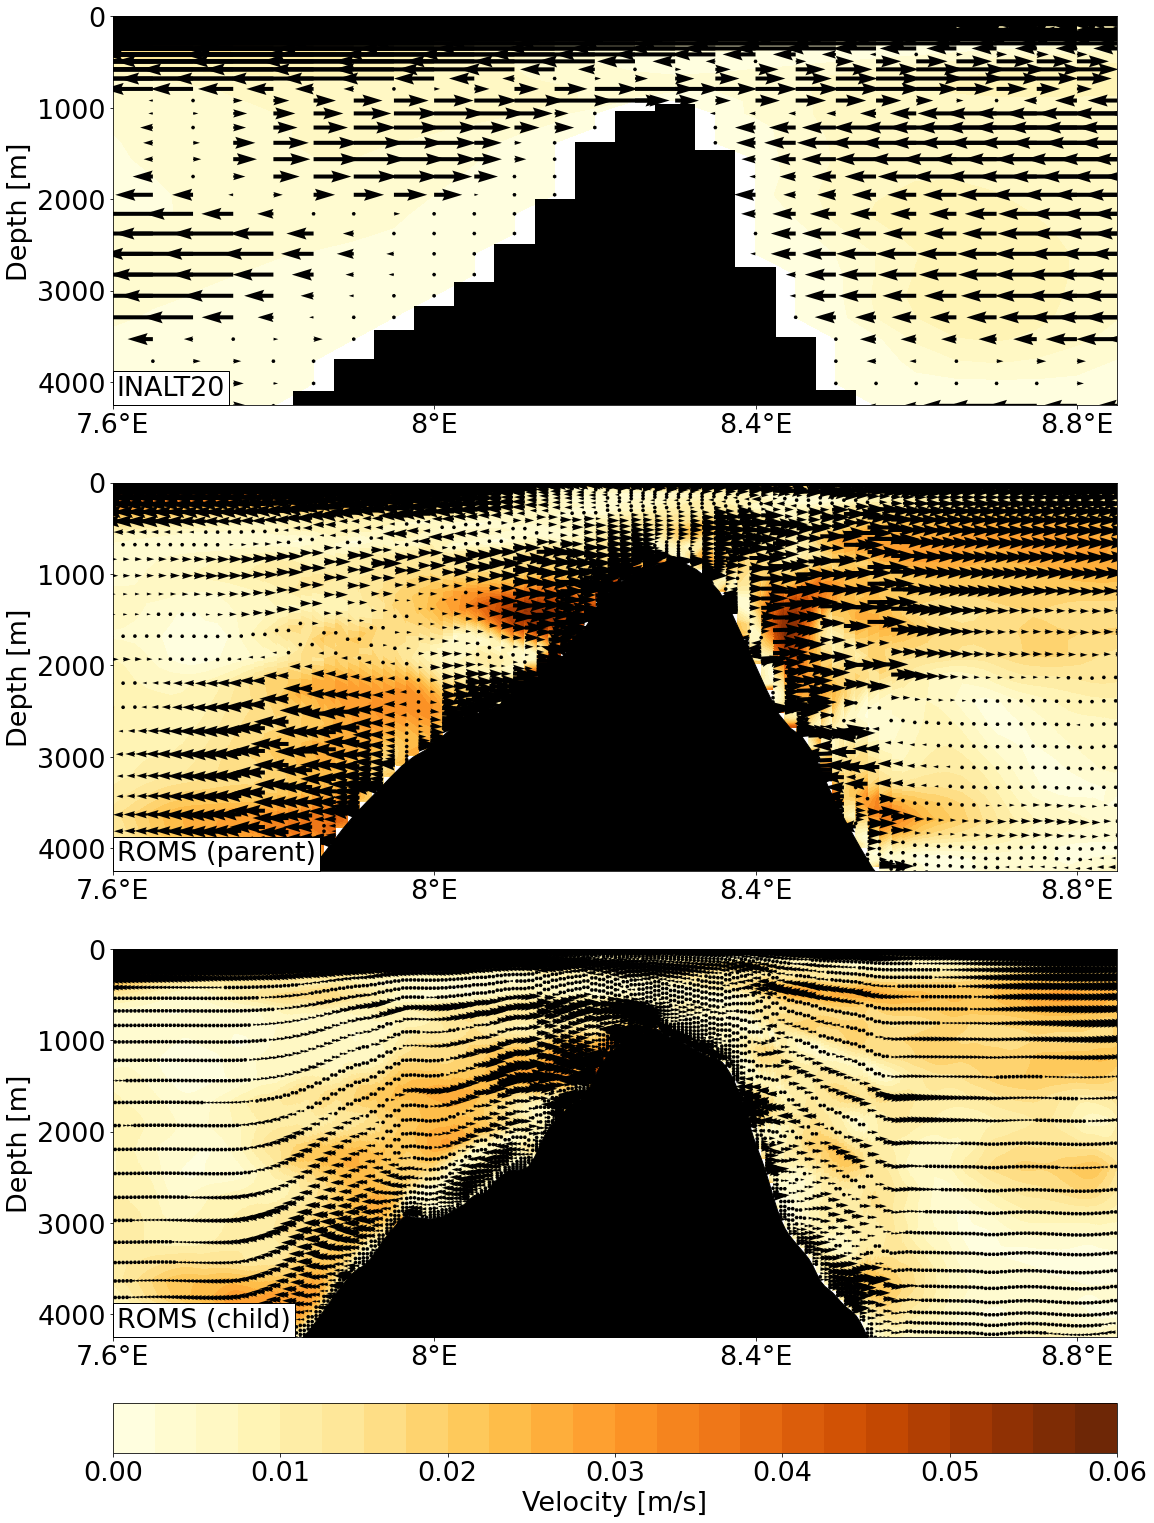

In [36]:
plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 30))

cf = ax1.contourf(velW_INALT_zon.nav_lon, topo_INALT_bar.max()-velW_INALT_zon.depth, velW_INALT_zon.vel, cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
ax1.quiver(velW_INALT_zon.nav_lon, topo_INALT_bar.max()-velW_INALT_zon.depth, velW_INALT_zon.vozocrtx, velW_INALT_zon.vovecrtz, scale=.03, color='black', width=0.004)
ax1.bar(np.linspace(0,18.05,362),topo_INALT_bar,width=0.05,label='INALT',color='black')


ax1.set_xlim([7.6,8.85])
ax1.set_xticks([7.6,8,8.4,8.8])
ax1.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax1.set_ylim([topo_INALT_bar.max()-4250,topo_INALT_bar.max()])
ax1.set_yticks(np.linspace(topo_INALT_bar.max()-4000,topo_INALT_bar.max()-0,5))
ax1.set_yticklabels(np.linspace(4000,0,5, dtype=int))
ax1.set_ylabel('Depth [m]')
ax1.text(*(7.605, topo_INALT_bar.max()-4210),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

#########################################
for i in [int(j) for j in np.linspace(0,len(ROMS_levels_zon.lon_rho)-4,int((len(ROMS_levels_zon.lon_rho)-2)/2))]:
    cf = ax2.contourf(ROMS_levels_zon.isel(slev=0).lon_rho[i:i+2],ROMS_levels_zon.max()-ROMS_levels_zon.isel(lon_rho=i),
                      vel_W_ROMS.vel.isel(eta=128,xi=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
for i in [int(j) for j in np.linspace(1,len(ROMS_levels_zon.lon_rho)-3,int(len(ROMS_levels_zon.lon_rho-2)/2)-1)]:
    cf = ax2.contourf(ROMS_levels_zon.isel(slev=0).lon_rho[i:i+2],ROMS_levels_zon.max()-ROMS_levels_zon.isel(lon_rho=i),
                      vel_W_ROMS.vel.isel(eta=128,xi=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
    
for i in [int(j) for j in np.linspace(0,len(ROMS_levels_zon.lon_rho)-4,int((len(ROMS_levels_zon.lon_rho)-2)/2))]:
    q= ax2.quiver(ROMS_levels_zon.isel(slev=0).lon_rho[i:i+2],ROMS_levels_zon.max()-ROMS_levels_zon.isel(lon_rho=i),
                  vel_W_ROMS.isel(eta=128,xi=slice(i,i+2)).u,-vel_W_ROMS.isel(eta=128,xi=slice(i,i+2)).w,
                 scale=0.6,width=0.004)
ax2.fill_between(np.linspace(6.524706,9.995295,238), 0, topo_ROMS_bar,color='black',label='ROMS parent')
                             
ax2.set_xlim([7.6,8.85])
ax2.set_xticks([7.6,8,8.4,8.8])
ax2.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax2.set_ylim([ROMS_levels_zon.max()-4250,ROMS_levels_zon.max()])
ax2.set_yticks(np.linspace(ROMS_levels_zon.max()-4000,ROMS_levels_zon.max(),5))
ax2.set_yticklabels(np.linspace(4000,0,5, dtype=int))
ax2.set_ylabel('Depth [m]')
ax2.text(*(7.605, ROMS_levels_zon.max()-4200),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

############################################################
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels_zon.lon_rho)-4,int((len(ROMS_child_levels_zon.lon_rho)-2)/2))]:
    cf = ax3.contourf(ROMS_child_levels_zon.isel(slev=0).lon_rho[i:i+2],ROMS_child_levels_zon.max()-ROMS_child_levels_zon.isel(lon_rho=i),
                      vel_W_ROMSchild.vel.isel(eta=139,xi=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
for i in [int(j) for j in np.linspace(1,len(ROMS_child_levels_zon.lon_rho)-3,int(len(ROMS_child_levels_zon.lon_rho)/2)-1)]:
    cf = ax3.contourf(ROMS_child_levels_zon.isel(slev=0).lon_rho[i:i+2],ROMS_child_levels_zon.max()-ROMS_child_levels_zon.isel(lon_rho=i),
                      vel_W_ROMSchild.vel.isel(eta=139,xi=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
    
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels_zon.lon_rho)-4,int((len(ROMS_child_levels_zon.lon_rho)-2)/2))]:
    q= ax3.quiver(ROMS_child_levels_zon.isel(slev=0).lon_rho[i:i+2],ROMS_child_levels_zon.max()-ROMS_child_levels_zon.isel(lon_rho=i),
                  vel_W_ROMSchild.isel(eta=139,xi=slice(i,i+2)).u,-vel_W_ROMSchild.isel(eta=139,xi=slice(i,i+2)).w,
                 scale=1,width=0.004)
ax3.fill_between(np.linspace(7.559,8.858,266), 0, topo_ROMS_child_bar,color='black',label='ROMS child')
                             
ax3.set_xlim([7.6,8.85])
ax3.set_xticks([7.6,8,8.4,8.8])
ax3.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax3.set_ylim([ROMS_child_levels_zon.max()-4250,ROMS_child_levels_zon.max()-0])
ax3.set_yticks(np.linspace(ROMS_child_levels_zon.max()-4000,ROMS_child_levels_zon.max()-0,5))
ax3.set_yticklabels(np.linspace(4000,0,5, dtype=int))
ax3.set_ylabel('Depth [m]')
ax3.text(*(7.605, ROMS_child_levels_zon.max()-4200),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))


cbar = plt.colorbar(cf, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.06, 7))
cbar.set_label('Velocity [m/s]')

plt.savefig('../../output_data/flowfield-mean-sideview-arrows.png', bbox_inches='tight')


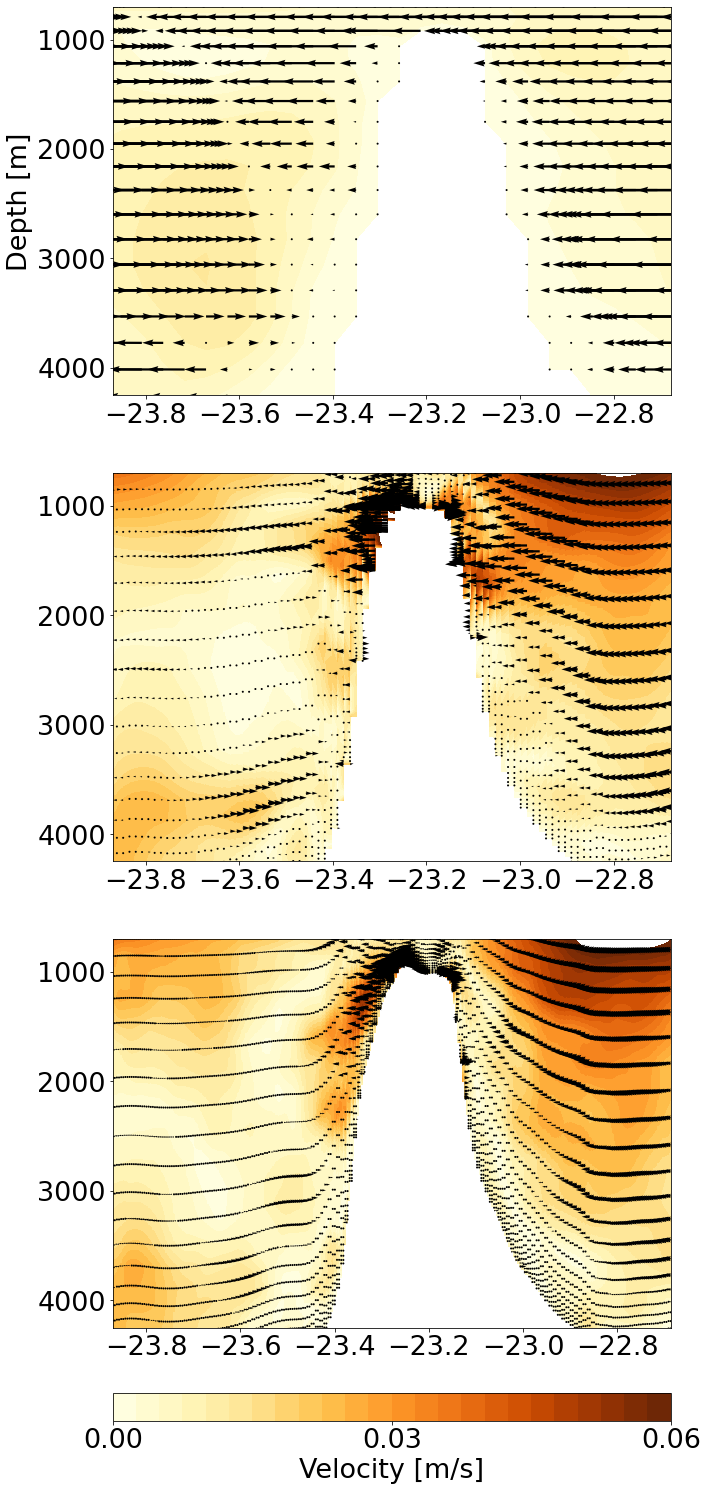

In [37]:
plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

cf = ax1.contourf(velW_INALT_mer.nav_lat, topo_INALT_bar_mer.max()-velW_INALT_mer.depth, velW_INALT_mer.vel, cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
ax1.quiver(velW_INALT_mer.nav_lat, topo_INALT_bar_mer.max()-velW_INALT_zon.depth, velW_INALT_mer.vomecrty, velW_INALT_mer.vovecrtz, scale=.03, color='black', width=0.004)
#ax1.bar(np.linspace(-36.01364,-17.949007,409),topo_INALT_bar_mer,width=0.05,label='INALT',color='black')

ax1.set_xlim([-23.870966,-22.677746])
#ax1.set_xticks([7.6,8,8.4,8.8])
#ax1.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax1.set_ylim([topo_INALT_bar_mer.max()-4250,topo_INALT_bar_mer.max()-700])
ax1.set_yticks(np.linspace(topo_INALT_bar_mer.max()-4000,topo_INALT_bar_mer.max()-1000,4))
ax1.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
ax1.set_ylabel('Depth [m]')
#ax1.text(*(6.525, -24.975),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

#########################################
for i in [int(j) for j in np.linspace(0,len(ROMS_levels_mer.lat_rho)-4,int((len(ROMS_levels_mer.lat_rho)-2)/2))]:
    cf = ax2.contourf(ROMS_levels_mer.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer.max()-ROMS_levels_mer.isel(lat_rho=i),
                      vel_W_ROMS.vel.isel(xi=118,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
for i in [int(j) for j in np.linspace(1,len(ROMS_levels_mer.lat_rho)-3,int(len(ROMS_levels_mer.lat_rho-2)/2)-1)]:
    cf = ax2.contourf(ROMS_levels_mer.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer.max()-ROMS_levels_mer.isel(lat_rho=i),
                      vel_W_ROMS.vel.isel(xi=118,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
    
for i in [int(j) for j in np.linspace(0,len(ROMS_levels_mer.lat_rho)-4,int((len(ROMS_levels_mer.lat_rho)-2)/2))]:
    q= ax2.quiver(ROMS_levels_mer.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer.max()-ROMS_levels_mer.isel(lat_rho=i),
                  vel_W_ROMS.isel(xi=118,eta=slice(i,i+2)).v,-vel_W_ROMS.isel(xi=118,eta=slice(i,i+2)).w,
                 scale=0.6,width=0.004)
#ax2.fill_between(np.linspace(-24.96,-21.487732,258), 0, topo_ROMS_bar_mer,color='black',label='ROMS parent')
                             
ax2.set_xlim([-23.870966,-22.677746])
#ax2.set_xticks([7.6,8,8.4,8.8])
#ax2.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax2.set_ylim([ROMS_levels_mer.max()-4250,ROMS_levels_mer.max()-700])
ax2.set_yticks(np.linspace(ROMS_levels_mer.max()-4000,ROMS_levels_mer.max()-1000,4))
ax2.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
#ax2.text(*(6.535, -24.93),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

############################################################
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels_mer.lat_rho)-4,int((len(ROMS_child_levels_mer.lat_rho)-2)/2))]:
    cf = ax3.contourf(ROMS_child_levels_mer.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer.max()-ROMS_child_levels_mer.isel(lat_rho=i),
                      vel_W_ROMSchild.vel.isel(xi=140,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
for i in [int(j) for j in np.linspace(1,len(ROMS_child_levels_mer.lat_rho)-3,int(len(ROMS_child_levels_mer.lat_rho)/2)-1)]:
    cf = ax3.contourf(ROMS_child_levels_mer.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer.max()-ROMS_child_levels_mer.isel(lat_rho=i),
                      vel_W_ROMSchild.vel.isel(xi=140,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
    
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels_mer.lat_rho)-4,int((len(ROMS_child_levels_mer.lat_rho)-2)/2))]:
    q= ax3.quiver(ROMS_child_levels_mer.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer.max()-ROMS_child_levels_mer.isel(lat_rho=i),
                  vel_W_ROMSchild.isel(xi=140,eta=slice(i,i+2)).v,-vel_W_ROMSchild.isel(xi=140,eta=slice(i,i+2)).w,
                 scale=1,width=0.004)
#ax3.fill_between(np.linspace(-23.870966,-22.677746,266), 0, topo_ROMS_child_bar_mer,color='black',label='ROMS child')
                             
#ax3.set_xlim([-23.870966,-22.677746])
#ax3.set_xticks([7.6,8,8.4,8.8])
#ax3.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax3.set_ylim([ROMS_child_levels_mer.max()-4250,ROMS_child_levels_mer.max()-700])
ax3.set_yticks(np.linspace(ROMS_child_levels_mer.max()-4000,ROMS_child_levels_mer.max()-1000,4))
ax3.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
#ax3.text(*(7.806, -23.694),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))


cbar = plt.colorbar(cf, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.15, 6))
cbar.set_label('Velocity [m/s]')

plt.savefig('../../output_data/flowfield-mean-sideview-mer825.png', bbox_inches='tight')


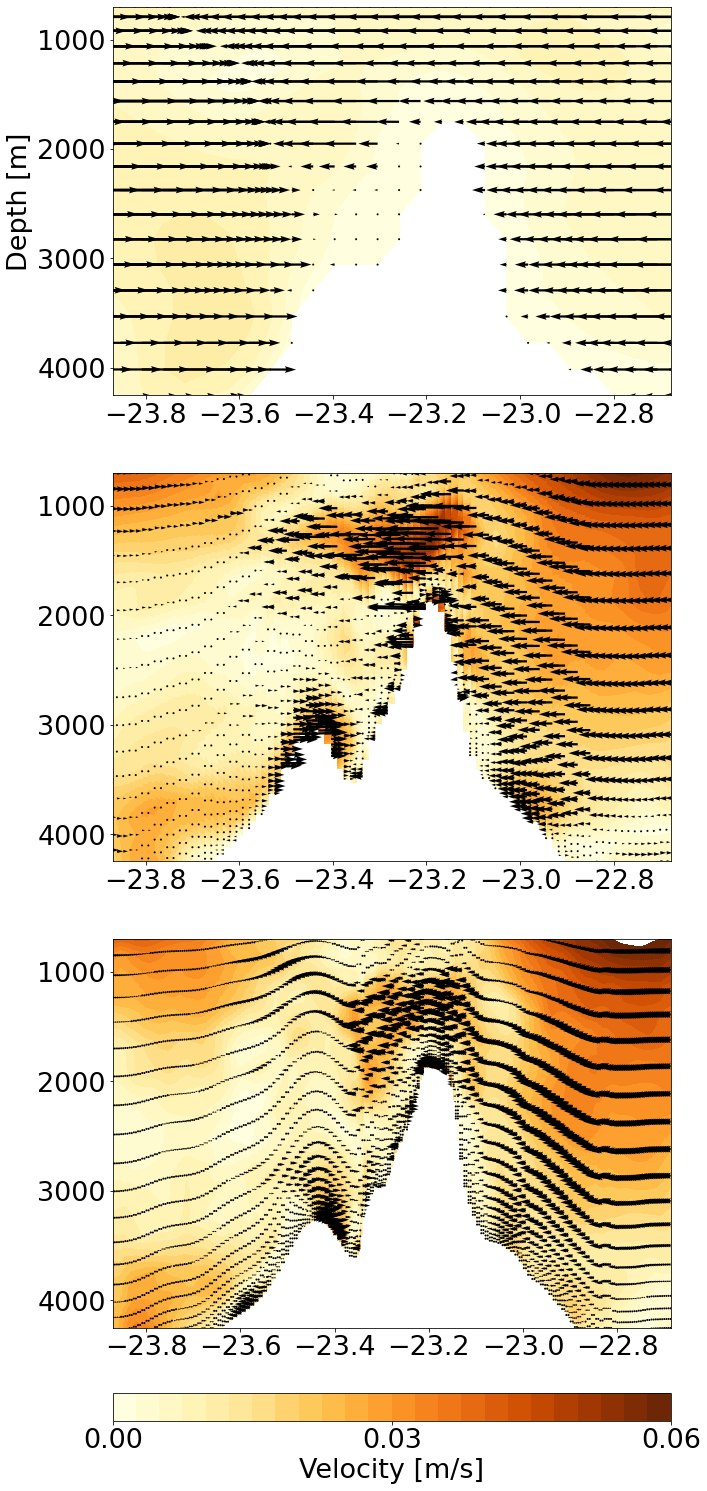

In [38]:
# Meriodional at 8.1E

plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

cf = ax1.contourf(velW_INALT_mer_1.nav_lat, topo_INALT_bar_mer.max()-velW_INALT_mer_1.depth, velW_INALT_mer_1.vel, cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
ax1.quiver(velW_INALT_mer_1.nav_lat, topo_INALT_bar_mer.max()-velW_INALT_mer_1.depth, velW_INALT_mer_1.vomecrty, velW_INALT_mer_1.vovecrtz, scale=.03, color='black', width=0.004)
#ax1.bar(np.linspace(-36.01364,-17.949007,409),topo_INALT_bar_mer,width=0.05,label='INALT',color='black')

ax1.set_xlim([-23.870966,-22.677746])
#ax1.set_xticks([7.6,8,8.4,8.8])
#ax1.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax1.set_ylim([topo_INALT_bar_mer.max()-4250,topo_INALT_bar_mer.max()-700])
ax1.set_yticks(np.linspace(topo_INALT_bar_mer.max()-4000,topo_INALT_bar_mer.max()-1000,4))
ax1.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
ax1.set_ylabel('Depth [m]')
#ax1.text(*(6.525, -24.975),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

#########################################
for i in [int(j) for j in np.linspace(0,len(ROMS_levels_mer_1.lat_rho)-4,int((len(ROMS_levels_mer_1.lat_rho)-2)/2))]:
    cf = ax2.contourf(ROMS_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer_1.max()-ROMS_levels_mer_1.isel(lat_rho=i),
                      vel_W_ROMS.vel.isel(xi=108,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
for i in [int(j) for j in np.linspace(1,len(ROMS_levels_mer_1.lat_rho)-3,int(len(ROMS_levels_mer_1.lat_rho-2)/2)-1)]:
    cf = ax2.contourf(ROMS_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer_1.max()-ROMS_levels_mer_1.isel(lat_rho=i),
                      vel_W_ROMS.vel.isel(xi=108,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
    
for i in [int(j) for j in np.linspace(0,len(ROMS_levels_mer_1.lat_rho)-4,int((len(ROMS_levels_mer_1.lat_rho)-2)/2))]:
    q= ax2.quiver(ROMS_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer_1.max()-ROMS_levels_mer_1.isel(lat_rho=i),
                  vel_W_ROMS.isel(xi=108,eta=slice(i,i+2)).v,-vel_W_ROMS.isel(xi=108,eta=slice(i,i+2)).w,
                 scale=0.6,width=0.004)
#ax2.fill_between(np.linspace(-24.96,-21.487732,258), 0, topo_ROMS_bar_mer,color='black',label='ROMS parent')
                             
ax2.set_xlim([-23.870966,-22.677746])
#ax2.set_xticks([7.6,8,8.4,8.8])
#ax2.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax2.set_ylim([ROMS_levels_mer_1.max()-4250,ROMS_levels_mer_1.max()-700])
ax2.set_yticks(np.linspace(ROMS_levels_mer_1.max()-4000,ROMS_levels_mer_1.max()-1000,4))
ax2.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
#ax2.text(*(6.535, -24.93),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

############################################################
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels_mer_1.lat_rho)-4,int((len(ROMS_child_levels_mer_1.lat_rho)-2)/2))]:
    cf = ax3.contourf(ROMS_child_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer_1.max()-ROMS_child_levels_mer_1.isel(lat_rho=i),
                      vel_W_ROMSchild.vel.isel(xi=115,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
for i in [int(j) for j in np.linspace(1,len(ROMS_child_levels_mer_1.lat_rho)-3,int(len(ROMS_child_levels_mer_1.lat_rho)/2)-1)]:
    cf = ax3.contourf(ROMS_child_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer_1.max()-ROMS_child_levels_mer_1.isel(lat_rho=i),
                      vel_W_ROMSchild.vel.isel(xi=115,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
    
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels_mer_1.lat_rho)-4,int((len(ROMS_child_levels_mer_1.lat_rho)-2)/2))]:
    q= ax3.quiver(ROMS_child_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer_1.max()-ROMS_child_levels_mer_1.isel(lat_rho=i),
                  vel_W_ROMSchild.isel(xi=115,eta=slice(i,i+2)).v,-vel_W_ROMSchild.isel(xi=115,eta=slice(i,i+2)).w,
                 scale=1,width=0.004)
#ax3.fill_between(np.linspace(-23.870966,-22.677746,266), 0, topo_ROMS_child_bar_mer,color='black',label='ROMS child')
                             
#ax3.set_xlim([-23.870966,-22.677746])
#ax3.set_xticks([7.6,8,8.4,8.8])
#ax3.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax3.set_ylim([ROMS_child_levels_mer_1.max()-4250,ROMS_child_levels_mer_1.max()-700])
ax3.set_yticks(np.linspace(ROMS_child_levels_mer_1.max()-4000,ROMS_child_levels_mer_1.max()-1000,4))
ax3.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
#ax3.text(*(7.806, -23.694),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))


cbar = plt.colorbar(cf, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.15, 6))
cbar.set_label('Velocity [m/s]')

plt.savefig('../../output_data/flowfield-mean-sideview-mer810.png', bbox_inches='tight')


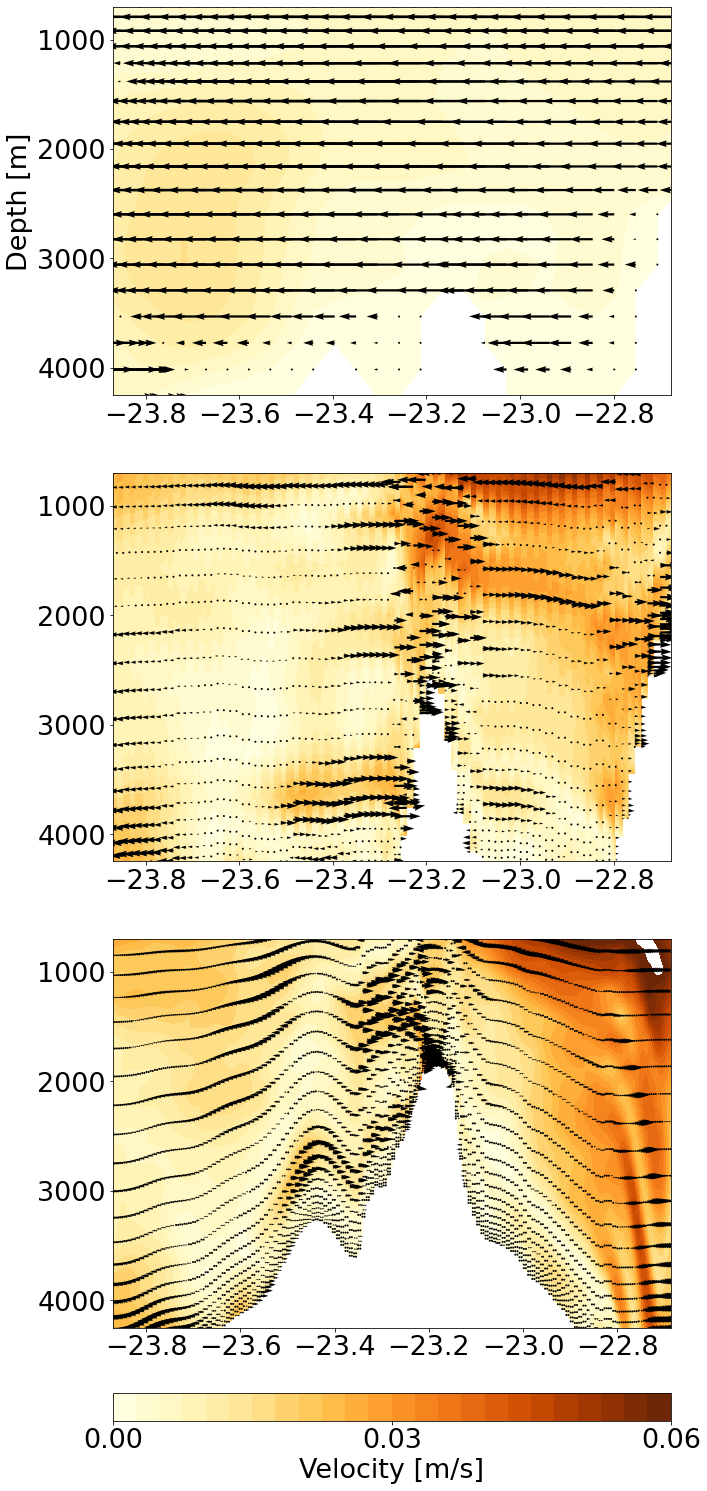

In [39]:
# Meriodional at 8.5E

plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

cf = ax1.contourf(velW_INALT_mer_2.nav_lat, topo_INALT_bar_mer.max()-velW_INALT_mer_2.depth, velW_INALT_mer_2.vel, cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
ax1.quiver(velW_INALT_mer_2.nav_lat, topo_INALT_bar_mer.max()-velW_INALT_mer_2.depth, velW_INALT_mer_2.vomecrty, velW_INALT_mer_2.vovecrtz, scale=.03, color='black', width=0.004)
#ax1.bar(np.linspace(-36.01364,-17.949007,409),topo_INALT_bar_mer,width=0.05,label='INALT',color='black')

ax1.set_xlim([-23.870966,-22.677746])
#ax1.set_xticks([7.6,8,8.4,8.8])
#ax1.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax1.set_ylim([topo_INALT_bar_mer.max()-4250,topo_INALT_bar_mer.max()-700])
ax1.set_yticks(np.linspace(topo_INALT_bar_mer.max()-4000,topo_INALT_bar_mer.max()-1000,4))
ax1.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
ax1.set_ylabel('Depth [m]')
#ax1.text(*(6.525, -24.975),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

#########################################
for i in [int(j) for j in np.linspace(0,len(ROMS_levels_mer_2.lat_rho)-4,int((len(ROMS_levels_mer_2.lat_rho)-2)/2))]:
    cf = ax2.contourf(ROMS_levels_mer_2.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer_2.max()-ROMS_levels_mer_2.isel(lat_rho=i),
                      vel_W_ROMS.vel.isel(xi=136,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
for i in [int(j) for j in np.linspace(1,len(ROMS_levels_mer_2.lat_rho)-3,int(len(ROMS_levels_mer_2.lat_rho-2)/2)-1)]:
    cf = ax2.contourf(ROMS_levels_mer_2.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer_1.max()-ROMS_levels_mer_2.isel(lat_rho=i),
                      vel_W_ROMS.vel.isel(xi=136,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
    
for i in [int(j) for j in np.linspace(0,len(ROMS_levels_mer_2.lat_rho)-4,int((len(ROMS_levels_mer_2.lat_rho)-2)/2))]:
    q= ax2.quiver(ROMS_levels_mer_2.isel(slev=0).lat_rho[i:i+2],ROMS_levels_mer_2.max()-ROMS_levels_mer_2.isel(lat_rho=i),
                  vel_W_ROMS.isel(xi=136,eta=slice(i,i+2)).v,-vel_W_ROMS.isel(xi=136,eta=slice(i,i+2)).w,
                 scale=0.6,width=0.004)
#ax2.fill_between(np.linspace(-24.96,-21.487732,258), 0, topo_ROMS_bar_mer,color='black',label='ROMS parent')
                             
ax2.set_xlim([-23.870966,-22.677746])
#ax2.set_xticks([7.6,8,8.4,8.8])
#ax2.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax2.set_ylim([ROMS_levels_mer_2.max()-4250,ROMS_levels_mer_2.max()-700])
ax2.set_yticks(np.linspace(ROMS_levels_mer_2.max()-4000,ROMS_levels_mer_2.max()-1000,4))
ax2.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
#ax2.text(*(6.535, -24.93),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

############################################################
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels_mer_1.lat_rho)-4,int((len(ROMS_child_levels_mer_1.lat_rho)-2)/2))]:
    cf = ax3.contourf(ROMS_child_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer_1.max()-ROMS_child_levels_mer_1.isel(lat_rho=i),
                      vel_W_ROMSchild.vel.isel(xi=193,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
for i in [int(j) for j in np.linspace(1,len(ROMS_child_levels_mer_1.lat_rho)-3,int(len(ROMS_child_levels_mer_1.lat_rho)/2)-1)]:
    cf = ax3.contourf(ROMS_child_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer_1.max()-ROMS_child_levels_mer_1.isel(lat_rho=i),
                      vel_W_ROMSchild.vel.isel(xi=193,eta=slice(i,i+2)),cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
    
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels_mer_1.lat_rho)-4,int((len(ROMS_child_levels_mer_1.lat_rho)-2)/2))]:
    q= ax3.quiver(ROMS_child_levels_mer_1.isel(slev=0).lat_rho[i:i+2],ROMS_child_levels_mer_1.max()-ROMS_child_levels_mer_1.isel(lat_rho=i),
                  vel_W_ROMSchild.isel(xi=193,eta=slice(i,i+2)).v,-vel_W_ROMSchild.isel(xi=193,eta=slice(i,i+2)).w,
                 scale=1,width=0.004)
#ax3.fill_between(np.linspace(-23.870966,-22.677746,266), 0, topo_ROMS_child_bar_mer,color='black',label='ROMS child')
                             
#ax3.set_xlim([-23.870966,-22.677746])
#ax3.set_xticks([7.6,8,8.4,8.8])
#ax3.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax3.set_ylim([ROMS_child_levels_mer_1.max()-4250,ROMS_child_levels_mer_1.max()-700])
ax3.set_yticks(np.linspace(ROMS_child_levels_mer_1.max()-4000,ROMS_child_levels_mer_1.max()-1000,4))
ax3.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
#ax3.text(*(7.806, -23.694),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))


cbar = plt.colorbar(cf, ax=[ax1, ax2, ax3], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.15, 6))
cbar.set_label('Velocity [m/s]')

plt.savefig('../../output_data/flowfield-mean-sideview-mer850.png', bbox_inches='tight')


In [40]:
%%time

INALT_mask_tides = xr.open_dataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_mesh_mask_iMirabilis.nc')
topo_INALT_tides = np.sum((INALT_mask_tides.tmask*INALT_mask_tides.e3t_0).isel(t=0),axis=0)
Ewing_topo_tides = topo_INALT_tides.isel(x=slice(110,220),y=slice(236,359))
U_INALT_tides = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_INALT20.L46-KFS104_1d_2009*_grid_U_iMirabilis.nc')
V_INALT_tides = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_INALT20.L46-KFS104_1d_2009*_grid_V_iMirabilis.nc')
Ewing_U_INALT_tides = U_INALT_tides.isel(x=slice(110,220),y=slice(236,359)).vozocrtx.compute()
Ewing_V_INALT_tides = V_INALT_tides.isel(x=slice(110,220),y=slice(236,359)).vomecrty.compute()

data_U_filled_INALT_tides = Ewing_U_INALT_tides.where(Ewing_U_INALT_tides != 0, np.nan).ffill(dim='depthu')
data_V_filled_INALT_tides = Ewing_V_INALT_tides.where(Ewing_V_INALT_tides != 0, np.nan).ffill(dim='depthv')
u_INALT_tides = data_U_filled_INALT_tides.isel(depthu=slice(0,46,45)).mean("time_counter")
v_INALT_tides = data_V_filled_INALT_tides.isel(depthv=slice(0,46,45)).mean("time_counter")
u_interp_INALT_tides = u_INALT_tides.rename({'depthu': 'depth'})#, 'eta_rho': 'eta', 'xi_u': 'xi'})
v_interp_INALT_tides = v_INALT_tides.rename({'depthv': 'depth'})#, 'eta_v': 'eta', 'xi_rho': 'xi'})
vel_INALT_tides = xr.combine_by_coords([u_interp_INALT_tides, v_interp_INALT_tides], compat='override', combine_attrs='drop_conflicts')
vel_INALT_tides["vel"] = np.sqrt(vel_INALT_tides.vomecrty**2 + vel_INALT_tides.vozocrtx**2)
vel_INALT_tides = vel_INALT_tides.compute()

CPU times: user 2.54 s, sys: 11.7 s, total: 14.2 s
Wall time: 19.6 s


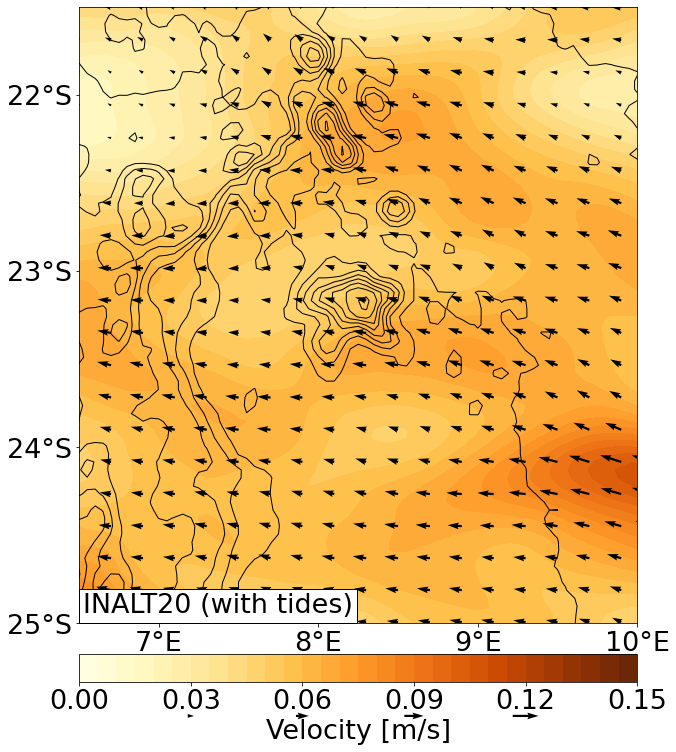

In [41]:
plt.rcParams.update({'font.size': 27})

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 14))

cf = ax1.contourf(vel_INALT_tides.nav_lon, vel_INALT_tides.nav_lat, vel_INALT_tides.vel.isel(depth=0), cmap='YlOrBr', levels=np.linspace(0, 0.15, 31))
ax1.contour(vel_INALT_tides.nav_lon, vel_INALT_tides.nav_lat, Ewing_topo_tides, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_INALT = vel_INALT_tides.isel(depth=0, y=slice(None, None, 4), x=slice(None, None, 4))
quiver=ax1.quiver(subset_vel_INALT.nav_lon, subset_vel_INALT.nav_lat, subset_vel_INALT.vozocrtx, subset_vel_INALT.vomecrty, scale=2.6, color='black', width=0.004)

ax1.set_xlim([6.5,10])
ax1.set_xticks([7,8,9,10])
ax1.set_xticklabels(['7°E','8°E','9°E','10°E'])
ax1.set_ylim([-25,-21.5])
ax1.set_yticks([-25,-24,-23,-22])
ax1.set_yticklabels(['25°S','24°S','23°S','22°S'])
ax1.text(*(6.525, -24.975),'INALT20 (with tides)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))


ax1.quiverkey(quiver, 0.2, -0.15, 0.03,'', coordinates='axes', linewidth=4)
ax1.quiverkey(quiver, 0.4, -0.15, 0.06,'', coordinates='axes', linewidth=4)
ax1.quiverkey(quiver, 0.6, -0.15, 0.09,'', coordinates='axes', linewidth=4)
ax1.quiverkey(quiver, 0.8, -0.15, 0.12,'', coordinates='axes', linewidth=4)

cbar = plt.colorbar(cf, ax=[ax1], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.15, 6))
cbar.set_label('Velocity [m/s]')

#plt.savefig('../../output_data/flowfield-mean-top.png', bbox_inches='tight')


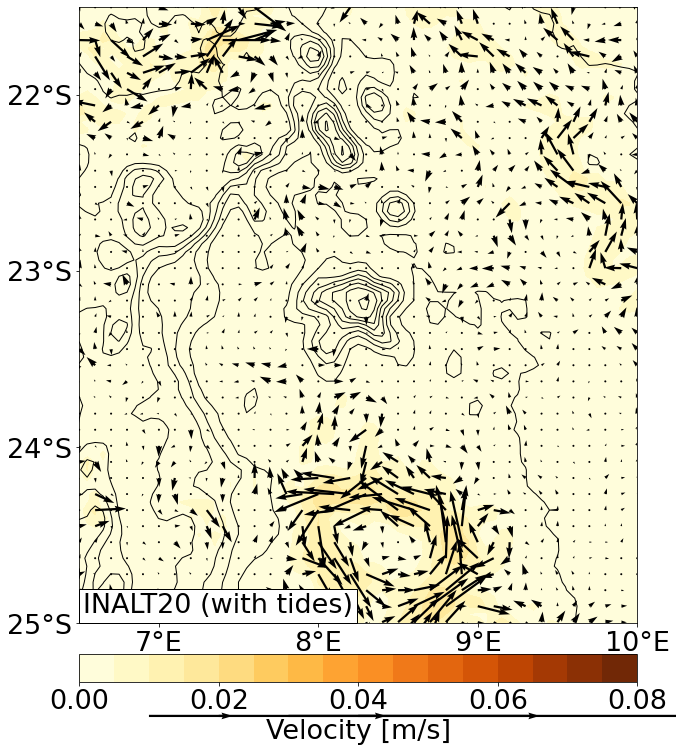

In [42]:
plt.rcParams.update({'font.size': 27})

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 14))

cf = ax1.contourf(vel_INALT_tides.nav_lon, vel_INALT_tides.nav_lat, vel_INALT_tides.vel.isel(depth=1), cmap='YlOrBr', levels=np.linspace(0, 0.08, 17))
ax1.contour(vel_INALT_tides.nav_lon, vel_INALT_tides.nav_lat, Ewing_topo_tides, colors='black', linewidths=1, levels=np.linspace(0,6500,14))
subset_vel_INALT = vel_INALT_tides.isel(depth=1, y=slice(None, None, 2), x=slice(None, None, 2))
quiver=ax1.quiver(subset_vel_INALT.nav_lon, subset_vel_INALT.nav_lat, subset_vel_INALT.vozocrtx, subset_vel_INALT.vomecrty, scale=.2, color='black', width=0.004)

ax1.set_xlim([6.5,10])
ax1.set_xticks([7,8,9,10])
ax1.set_xticklabels(['7°E','8°E','9°E','10°E'])
ax1.set_ylim([-25,-21.5])
ax1.set_yticks([-25,-24,-23,-22])
ax1.set_yticklabels(['25°S','24°S','23°S','22°S'])
ax1.text(*(6.525, -24.975),'INALT20 (with tides)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))


ax1.quiverkey(quiver, 0.2, -0.15, 0.03,'', coordinates='axes', linewidth=4)
ax1.quiverkey(quiver, 0.4, -0.15, 0.06,'', coordinates='axes', linewidth=4)
ax1.quiverkey(quiver, 0.6, -0.15, 0.09,'', coordinates='axes', linewidth=4)
ax1.quiverkey(quiver, 0.8, -0.15, 0.12,'', coordinates='axes', linewidth=4)

cbar = plt.colorbar(cf, ax=[ax1], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.08, 5))
cbar.set_label('Velocity [m/s]')

#plt.savefig('../../output_data/flowfield-mean-top.png', bbox_inches='tight')


In [43]:
%%time

Ewing_topo_zon_tides = topo_INALT_tides.isel(x=slice(110,220),y=295)
Ewing_topo_mer_tides = topo_INALT_tides.isel(x=165,y=slice(236,359))

W_INALT_tides = xr.open_mfdataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_INALT20.L46-KFS104_1d_2009*_grid_W_iMirabilis.nc')
Ewing_U_INALT_zon_tides = U_INALT_tides.isel(x=slice(110,220),y=295).vozocrtx.mean("time_counter").compute()
Ewing_V_INALT_zon_tides = V_INALT_tides.isel(x=slice(110,220),y=295).vomecrty.mean("time_counter").compute()
Ewing_W_INALT_zon_tides = W_INALT_tides.isel(x=slice(110,220),y=295).vovecrtz.mean("time_counter").compute()

Ewing_U_INALT_mer_tides = U_INALT_tides.isel(x=165,y=slice(236,359)).vozocrtx.mean("time_counter").compute()
Ewing_V_INALT_mer_tides = V_INALT_tides.isel(x=165,y=slice(236,359)).vomecrty.mean("time_counter").compute()
Ewing_W_INALT_mer_tides = W_INALT_tides.isel(x=165,y=slice(236,359)).vovecrtz.mean("time_counter").compute()

Ewing_U_INALT_zon_tides, Ewing_U_INALT_mer_tides = Ewing_U_INALT_zon_tides.rename({'depthu': 'depth'}), Ewing_U_INALT_mer_tides.rename({'depthu': 'depth'})
Ewing_V_INALT_zon_tides, Ewing_V_INALT_mer_tides = Ewing_V_INALT_zon_tides.rename({'depthv': 'depth'}), Ewing_V_INALT_mer_tides.rename({'depthv': 'depth'})
Ewing_W_INALT_zon_tides, Ewing_W_INALT_mer_tides = Ewing_W_INALT_zon_tides.rename({'depthw': 'depth'}), Ewing_W_INALT_mer_tides.rename({'depthw': 'depth'})

Ewing_U_INALT_zon_tides['depth'] = Ewing_W_INALT_zon_tides.depth
Ewing_V_INALT_zon_tides['depth'] = Ewing_W_INALT_zon_tides.depth
Ewing_U_INALT_mer_tides['depth'] = Ewing_W_INALT_mer_tides.depth
Ewing_V_INALT_mer_tides['depth'] = Ewing_W_INALT_mer_tides.depth


velW_INALT_zon_tides = xr.combine_by_coords([Ewing_U_INALT_zon_tides, Ewing_V_INALT_zon_tides, Ewing_W_INALT_zon_tides], compat='override', combine_attrs='drop_conflicts')
velW_INALT_zon_tides["vel"] = np.sqrt(velW_INALT_zon_tides.vomecrty**2 + velW_INALT_zon_tides.vozocrtx**2 + velW_INALT_zon_tides.vovecrtz**2)
velW_INALT_zon_tides = velW_INALT_zon_tides.compute()

velW_INALT_mer_tides = xr.combine_by_coords([Ewing_U_INALT_mer_tides, Ewing_V_INALT_mer_tides, Ewing_W_INALT_mer_tides], compat='override', combine_attrs='drop_conflicts')
velW_INALT_mer_tides["vel"] = np.sqrt(velW_INALT_mer_tides.vomecrty**2 + velW_INALT_mer_tides.vozocrtx**2 + velW_INALT_mer_tides.vovecrtz**2)
velW_INALT_mer_tides = velW_INALT_mer_tides.compute()

CPU times: user 221 ms, sys: 23.6 s, total: 23.8 s
Wall time: 43.6 s


In [44]:
#Calculate bottom topography in INALT
topo_INALT_tides = np.sum((INALT_mask_tides.tmask*INALT_mask_tides.e3t_0).isel(t=0),axis=0)
topo_INALT_tides = topo_INALT_tides.assign_coords({"lon": INALT_mask_tides.glamt.isel(t=0,y=0)})
topo_INALT_tides = topo_INALT_tides.assign_coords({"lat": INALT_mask_tides.gphit.isel(t=0,x=0)})
topo_INALT_tides = topo_INALT_tides.swap_dims({'x': 'lon'})
topo_INALT_tides = topo_INALT_tides.swap_dims({'y': 'lat'})

#Depths of levels in INALT and ROMS_tides
INALT_levels_tides = INALT_mask_tides.gdept_0
INALT_levels_tides = INALT_levels_tides.isel(y=0,t=0,x=0)

#Ewing Seamount Profile along latitude where the tip if the seamount is located
topo_INALT_bar_tides=topo_INALT_tides.isel(lat=295)
topo_INALT_bar_tides=-(topo_INALT_bar_tides-INALT_levels_tides.max())

#Ewing Seamount Profile along longitude where the tip if the seamount is located
topo_INALT_bar_mer_tides=topo_INALT_tides.isel(lon=165)
topo_INALT_bar_mer_tides=-(topo_INALT_bar_mer_tides-INALT_levels_tides.max())

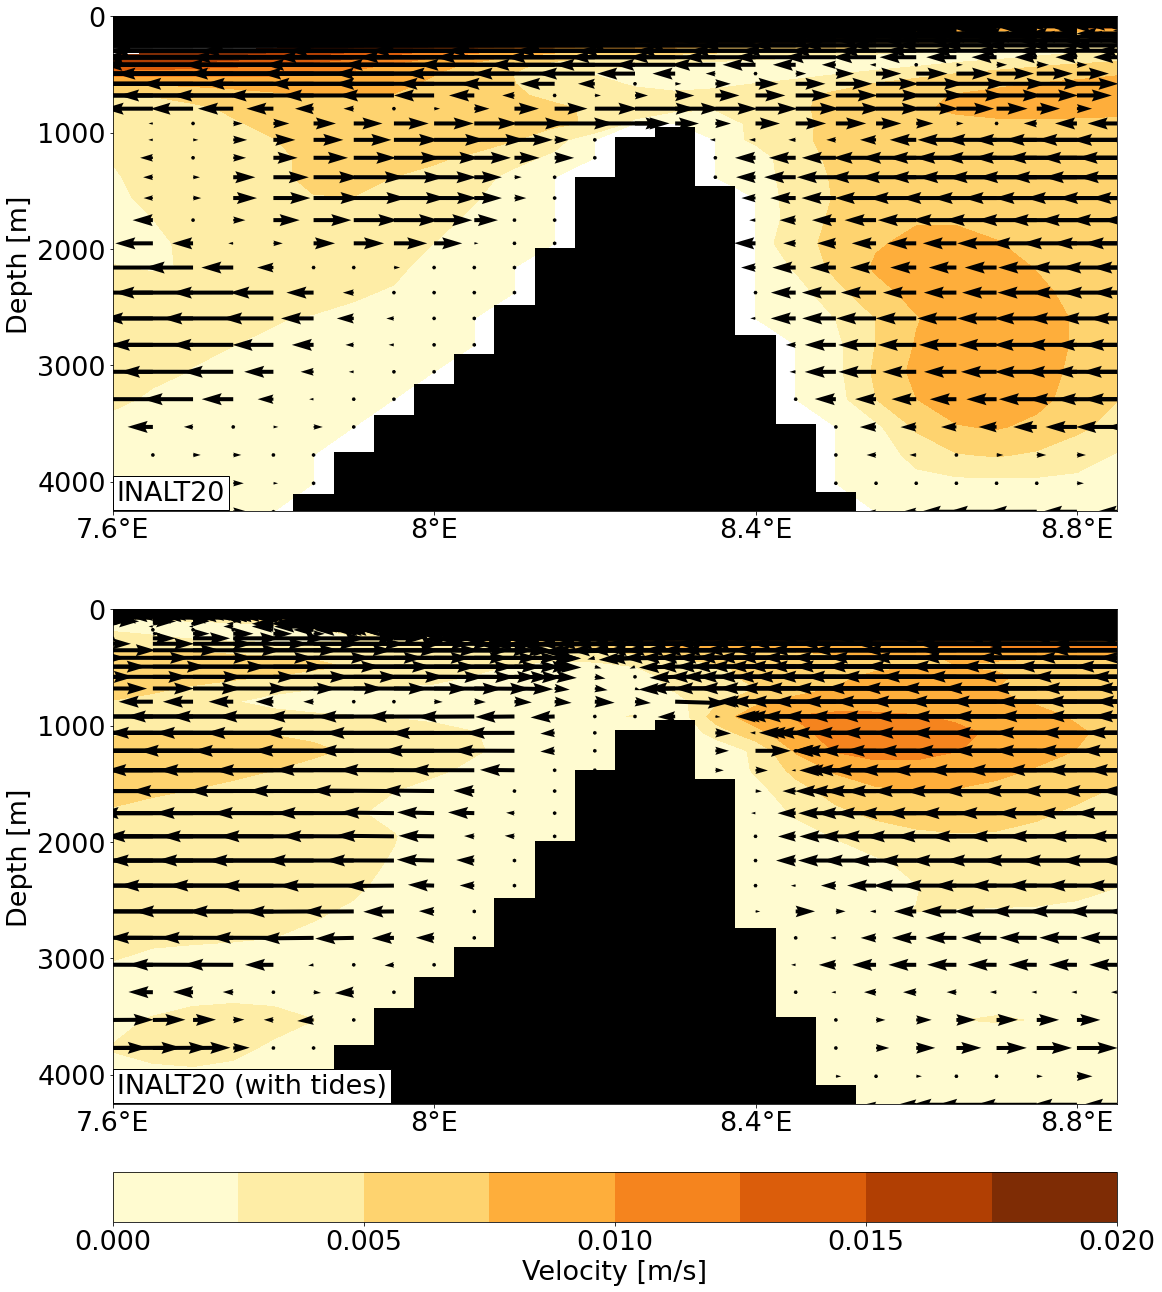

In [49]:
plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 25))

cf = ax1.contourf(velW_INALT_zon.nav_lon, topo_INALT_bar.max()-velW_INALT_zon.depth, velW_INALT_zon.vel, cmap='YlOrBr',levels=np.linspace(0, 0.02, 9))
ax1.quiver(velW_INALT_zon.nav_lon, topo_INALT_bar.max()-velW_INALT_zon.depth, velW_INALT_zon.vozocrtx, velW_INALT_zon.vovecrtz, scale=.03, color='black', width=0.004)
ax1.bar(np.linspace(0,18.05,362),topo_INALT_bar,width=0.05,label='INALT',color='black')


ax1.set_xlim([7.6,8.85])
ax1.set_xticks([7.6,8,8.4,8.8])
ax1.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax1.set_ylim([topo_INALT_bar.max()-4250,topo_INALT_bar.max()])
ax1.set_yticks(np.linspace(topo_INALT_bar.max()-4000,topo_INALT_bar.max()-0,5))
ax1.set_yticklabels(np.linspace(4000,0,5, dtype=int))
ax1.set_ylabel('Depth [m]')
ax1.text(*(7.605, topo_INALT_bar.max()-4210),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

##################################

cf = ax2.contourf(velW_INALT_zon_tides.nav_lon, topo_INALT_bar_tides.max()-velW_INALT_zon_tides.depth, velW_INALT_zon_tides.vel, cmap='YlOrBr',levels=np.linspace(0, 0.02, 9))
ax2.quiver(velW_INALT_zon_tides.nav_lon, topo_INALT_bar_tides.max()-velW_INALT_zon_tides.depth, velW_INALT_zon_tides.vozocrtx, velW_INALT_zon_tides.vovecrtz, scale=.03, color='black', width=0.004)
ax2.bar(np.linspace(0,33.05,662),topo_INALT_bar_tides,width=0.05,label='INALT',color='black')


ax2.set_xlim([7.6,8.85])
ax2.set_xticks([7.6,8,8.4,8.8])
ax2.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax2.set_ylim([topo_INALT_bar_tides.max()-4250,topo_INALT_bar_tides.max()])
ax2.set_yticks(np.linspace(topo_INALT_bar_tides.max()-4000,topo_INALT_bar_tides.max()-0,5))
ax2.set_yticklabels(np.linspace(4000,0,5, dtype=int))
ax2.set_ylabel('Depth [m]')
ax2.text(*(7.605, topo_INALT_bar_tides.max()-4210),'INALT20 (with tides)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

cbar = plt.colorbar(cf, ax=[ax1,ax2], orientation='horizontal', pad=0.05, ticks=np.linspace(0, 0.02, 5))
cbar.set_label('Velocity [m/s]')

plt.savefig('../../output_data/flowfield-INALT-tides.png', bbox_inches='tight')

TypeError: cannot unpack non-iterable AxesSubplot object

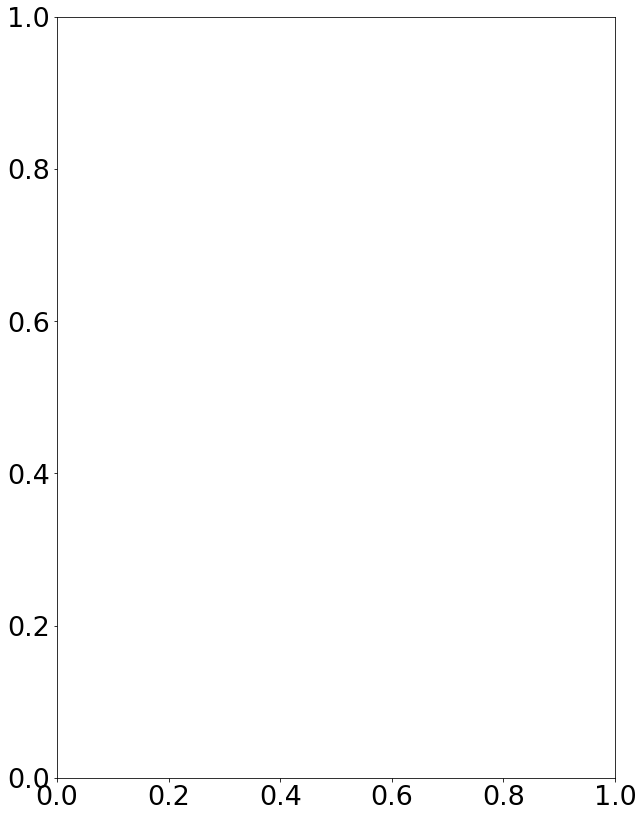

In [46]:
# Meriodional at 8.5E

plt.rcParams.update({'font.size': 27})

fig, (ax1, ax2, ax3) = plt.subplots(1, 1, figsize=(10, 14))

cf = ax1.contourf(velW_INALT_mer_2.nav_lat, topo_INALT_bar_mer.max()-velW_INALT_mer_2.depth, velW_INALT_mer_2.vel, cmap='YlOrBr',levels=np.linspace(0, 0.06, 25))
ax1.quiver(velW_INALT_mer_2.nav_lat, topo_INALT_bar_mer.max()-velW_INALT_mer_2.depth, velW_INALT_mer_2.vomecrty, velW_INALT_mer_2.vovecrtz, scale=.03, color='black', width=0.004)
#ax1.bar(np.linspace(-36.01364,-17.949007,409),topo_INALT_bar_mer,width=0.05,label='INALT',color='black')

ax1.set_xlim([-23.870966,-22.677746])
#ax1.set_xticks([7.6,8,8.4,8.8])
#ax1.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax1.set_ylim([topo_INALT_bar_mer.max()-4250,topo_INALT_bar_mer.max()-700])
ax1.set_yticks(np.linspace(topo_INALT_bar_mer.max()-4000,topo_INALT_bar_mer.max()-1000,4))
ax1.set_yticklabels(np.linspace(4000,1000,4, dtype=int))
ax1.set_ylabel('Depth [m]')
#ax1.text(*(6.525, -24.975),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))

cbar = plt.colorbar(cf, ax=[ax1], orientation='horizontal', pad=0.04, ticks=np.linspace(0, 0.15, 6))
cbar.set_label('Velocity [m/s]')

#plt.savefig('../../output_data/flowfield-mean-sideview-mer850.png', bbox_inches='tight')
